# Sandbox

For playing around and testing. The contents aren't meant to makes sense afterwards or even run in order.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import math


## ARotor TSA tests


In [4]:
data_folder = os.path.join("data")
raw_data_folder = os.path.join(data_folder, "RAW")
processed_data_folder = os.path.join(data_folder, "processed")

df = pd.read_feather(os.path.join(processed_data_folder, "arotor.feather"))
data_processed = df.groupby(["class", "rpm"])
# data_processed.first()


10000    840210.606
10001    840212.118
10002    840213.630
10003    840215.142
10004    840216.636
            ...    
15995    849185.892
15996    849187.386
15997    849188.880
15998    849190.374
15999    849191.868
Name: en1angle, Length: 6000, dtype: float64


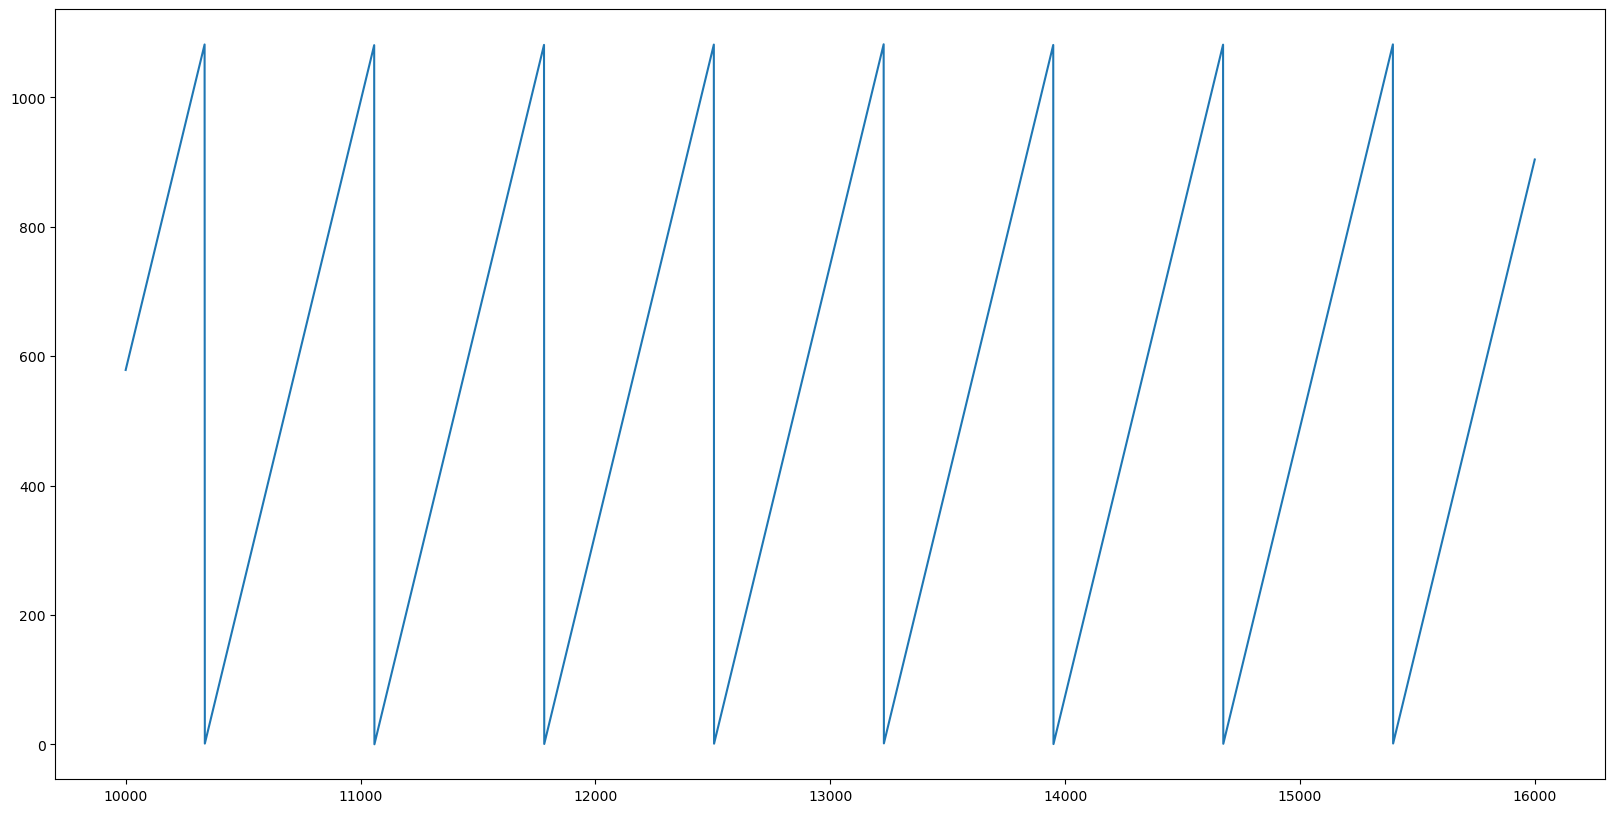

In [39]:
data_1_750 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_1sim_csv", "750rpm_0030_1sim_new_0.csv"), delimiter=";")
angle = data_1_750["en1angle"][10000:10000+6000]
print(angle)
rot_angle = angle % 1082
# angle
plt.figure(figsize=(20, 10))
plt.plot(rot_angle)

10000    15953.940
10001    15954.426
10002    15954.930
10003    15955.434
10004    15955.920
           ...    
15995    18945.612
15996    18946.116
15997    18946.602
15998    18947.106
15999    18947.610
Name: en1angle, Length: 6000, dtype: float64


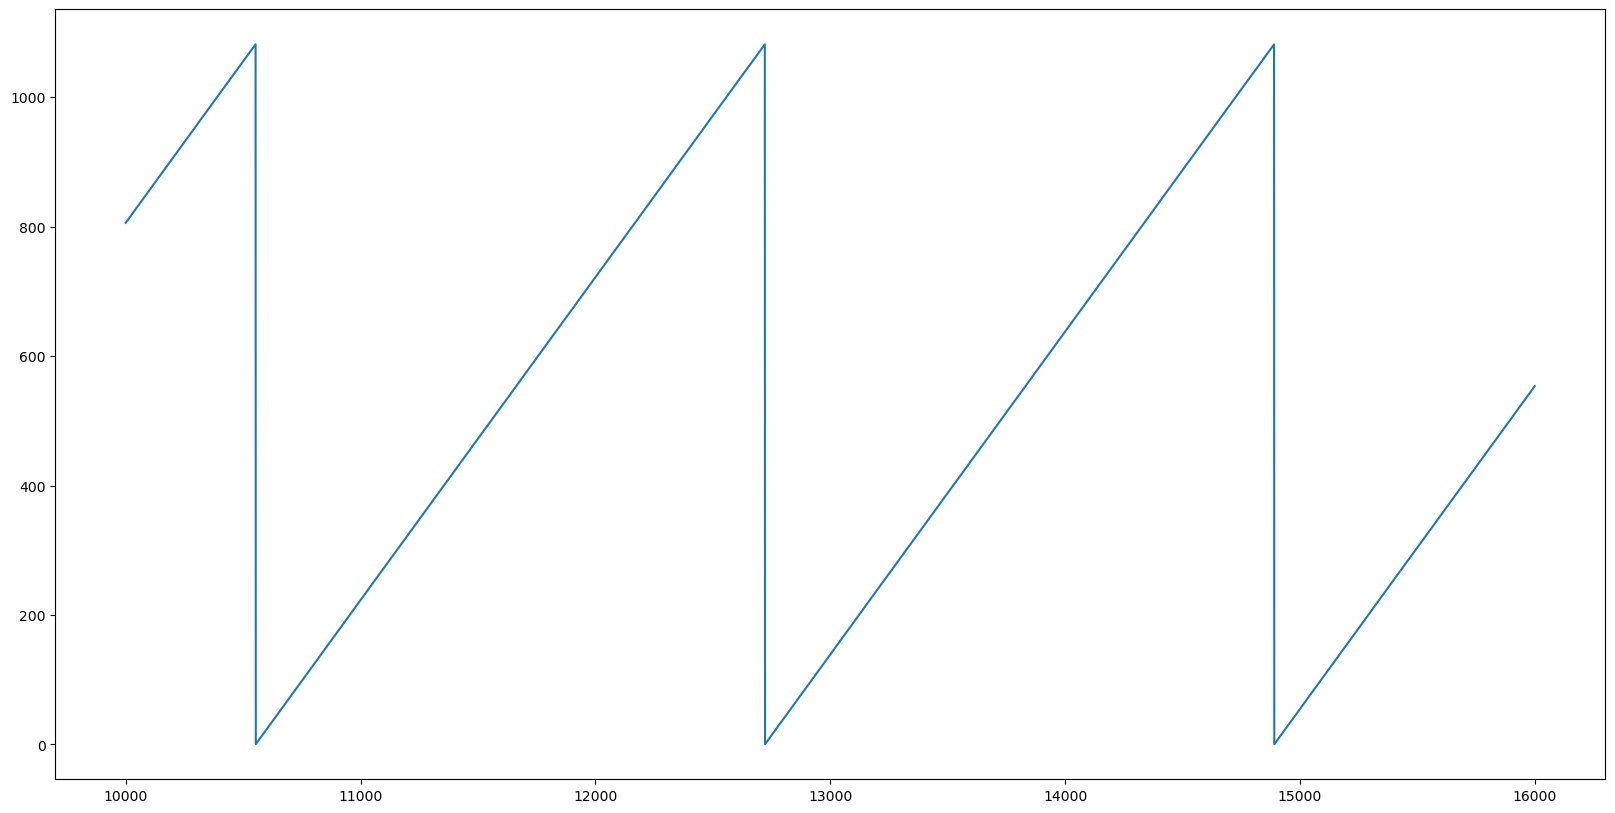

In [38]:
data_1_250 = pd.read_csv(os.path.join(raw_data_folder, "ARotor", "003_1sim_csv", "250rpm_0030_1sim_new_0.csv"), delimiter=";")
angle = data_1_250["en1angle"][10000:10000+6000]
print(angle)
rot_angle = angle % 1082
# angle
plt.figure(figsize=(20, 10))
plt.plot(rot_angle)

In [54]:
s = []

for i in range(8000):
    a = data_1_250["en1angle"][1000+i*50]
    b = data_1_250["en1angle"][1000+i*50+2169]
    s.append(b-a)

print(sum(s) / len(s))
# print(b - a)

1082.4241049999523


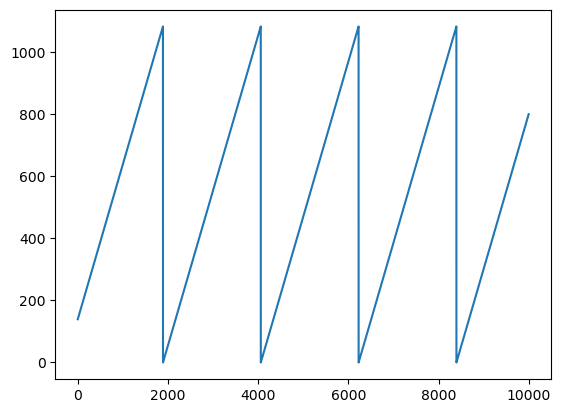

In [58]:
data_normalized = data_1_250["en1angle"] % 1082.424
plt.plot(data_normalized[:10000])

In [69]:
starts = []
for i in range(1, len(data_normalized)):
    if data_normalized[i-1] > data_normalized[i] and data_normalized[i] < 0.01:
        starts.append(i)
        # print(i, data_normalized[i], data_normalized[i-1])

        # if len(starts) > 10:
        #     break

print(len(starts))

12


In [70]:
speeds = []
for i in starts:
    speeds.append(np.gradient(data_normalized[i:i+2169], data_1_250["en1time"][i:i+2169]))

len(speeds)

12

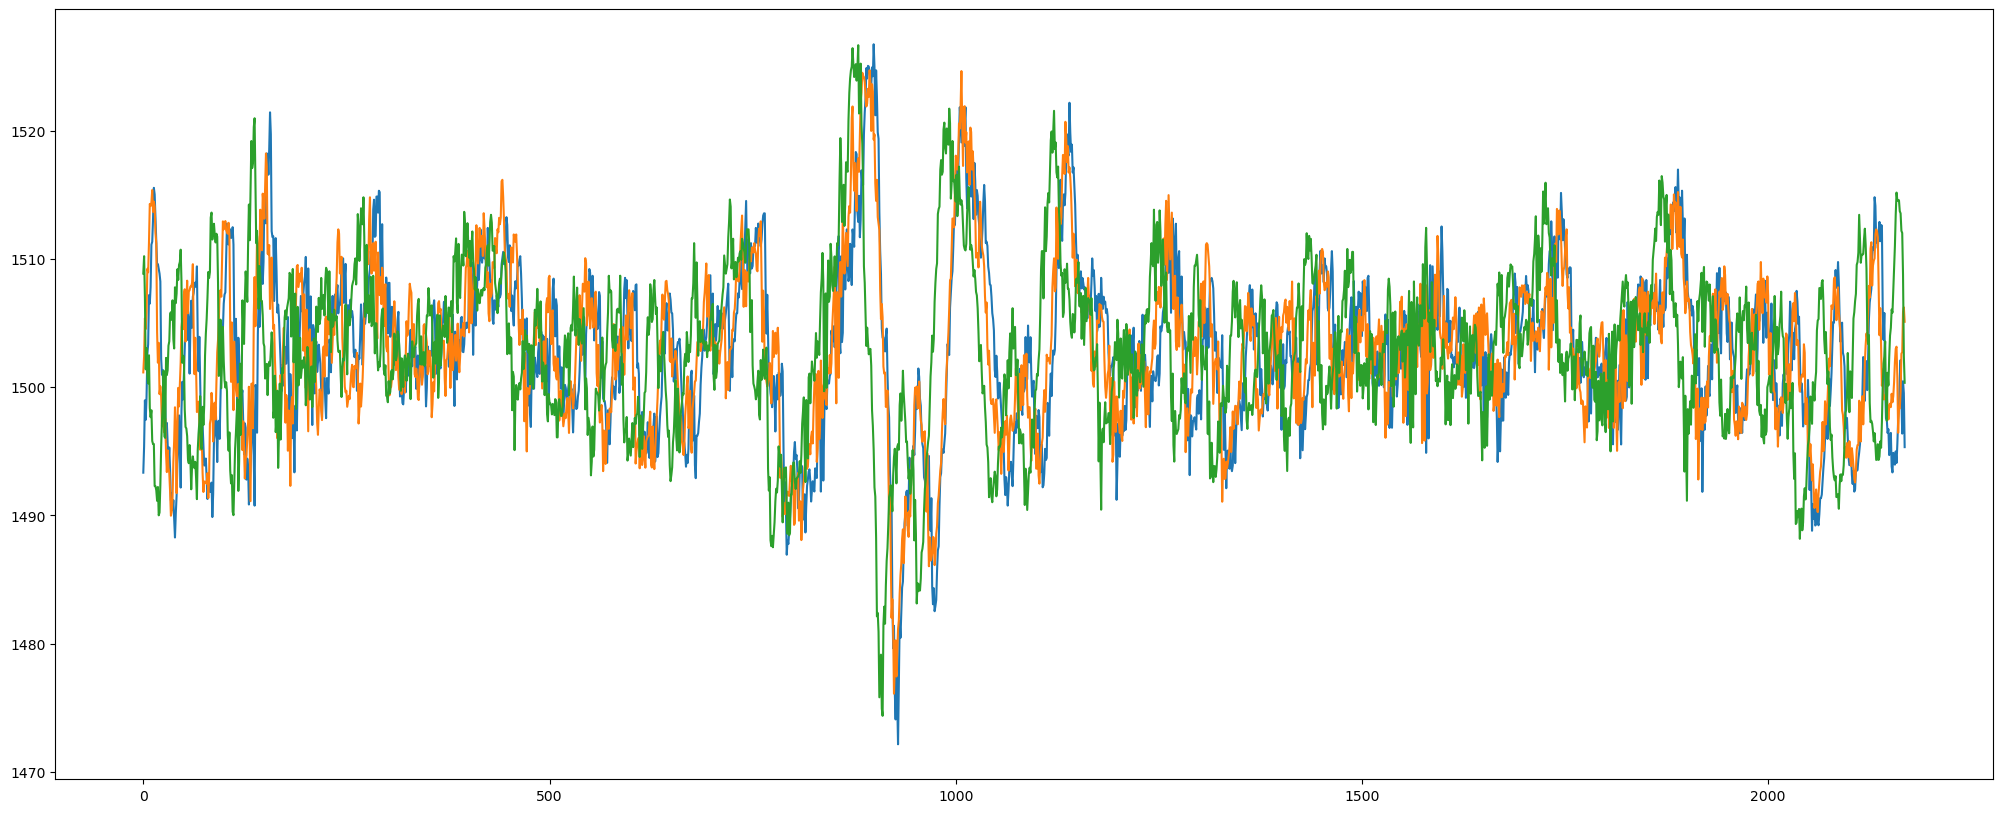

In [75]:
plt.figure(figsize=(25, 10))

for i in range(3):
    plt.plot(speeds[i])

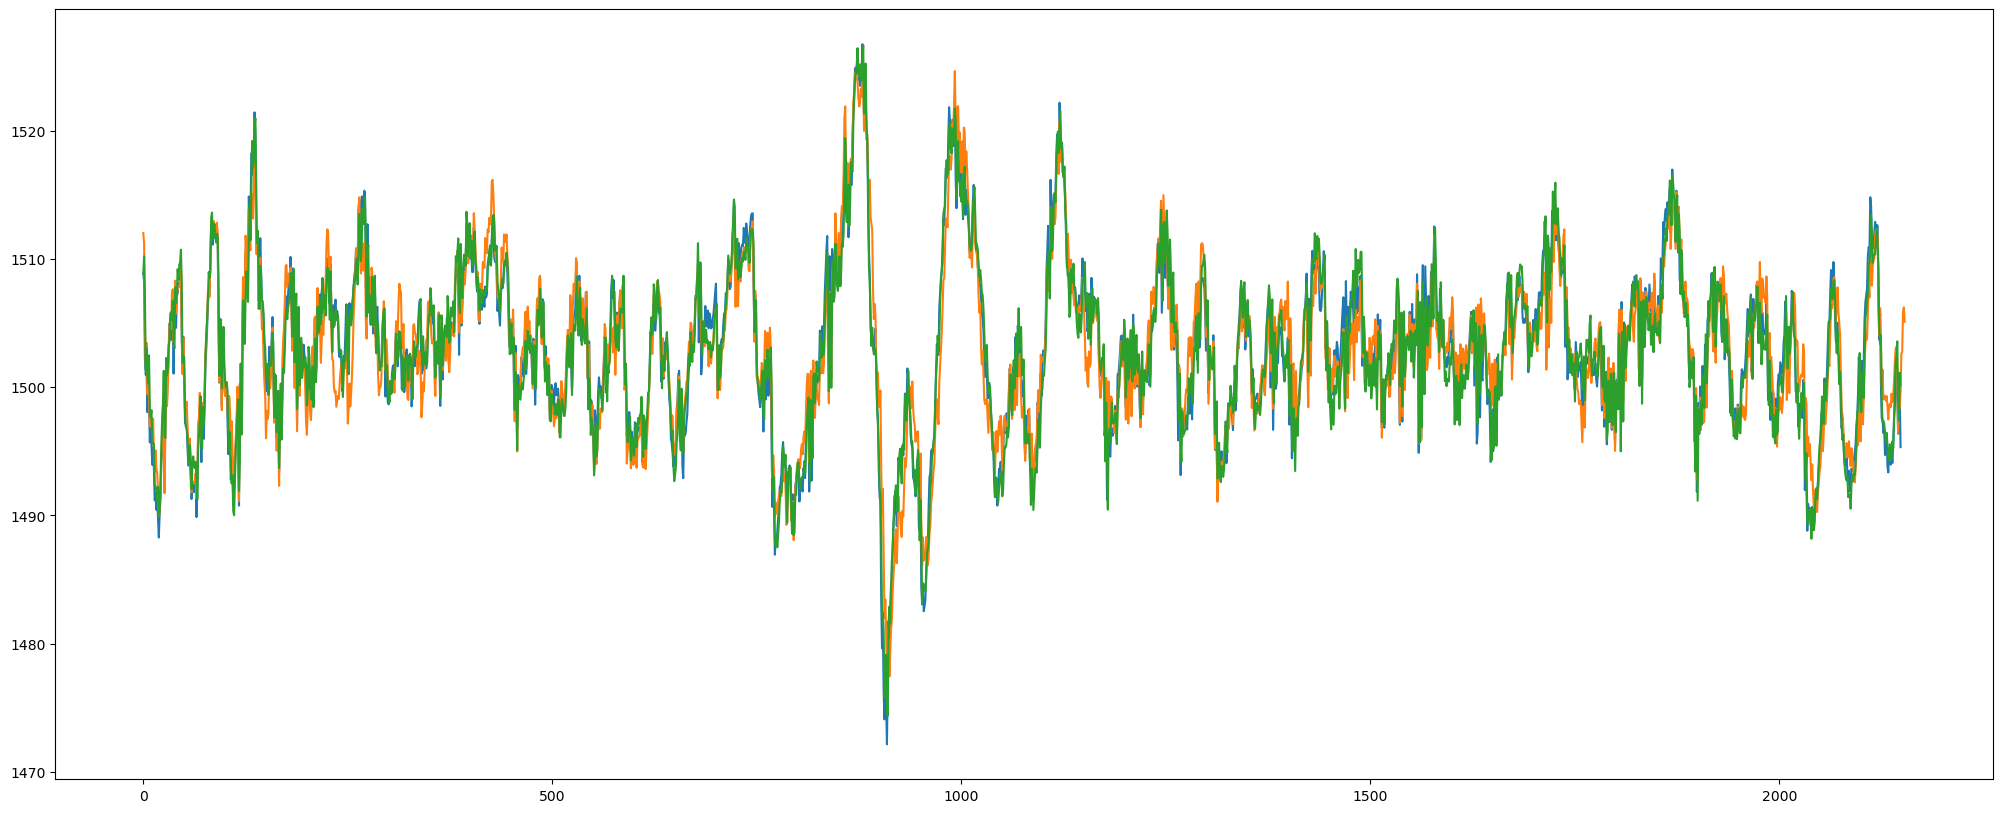

In [101]:
plt.figure(figsize=(25, 10))
plt.plot(speeds[0][20:])
plt.plot(speeds[1][15:])
plt.plot(speeds[2][:-20])

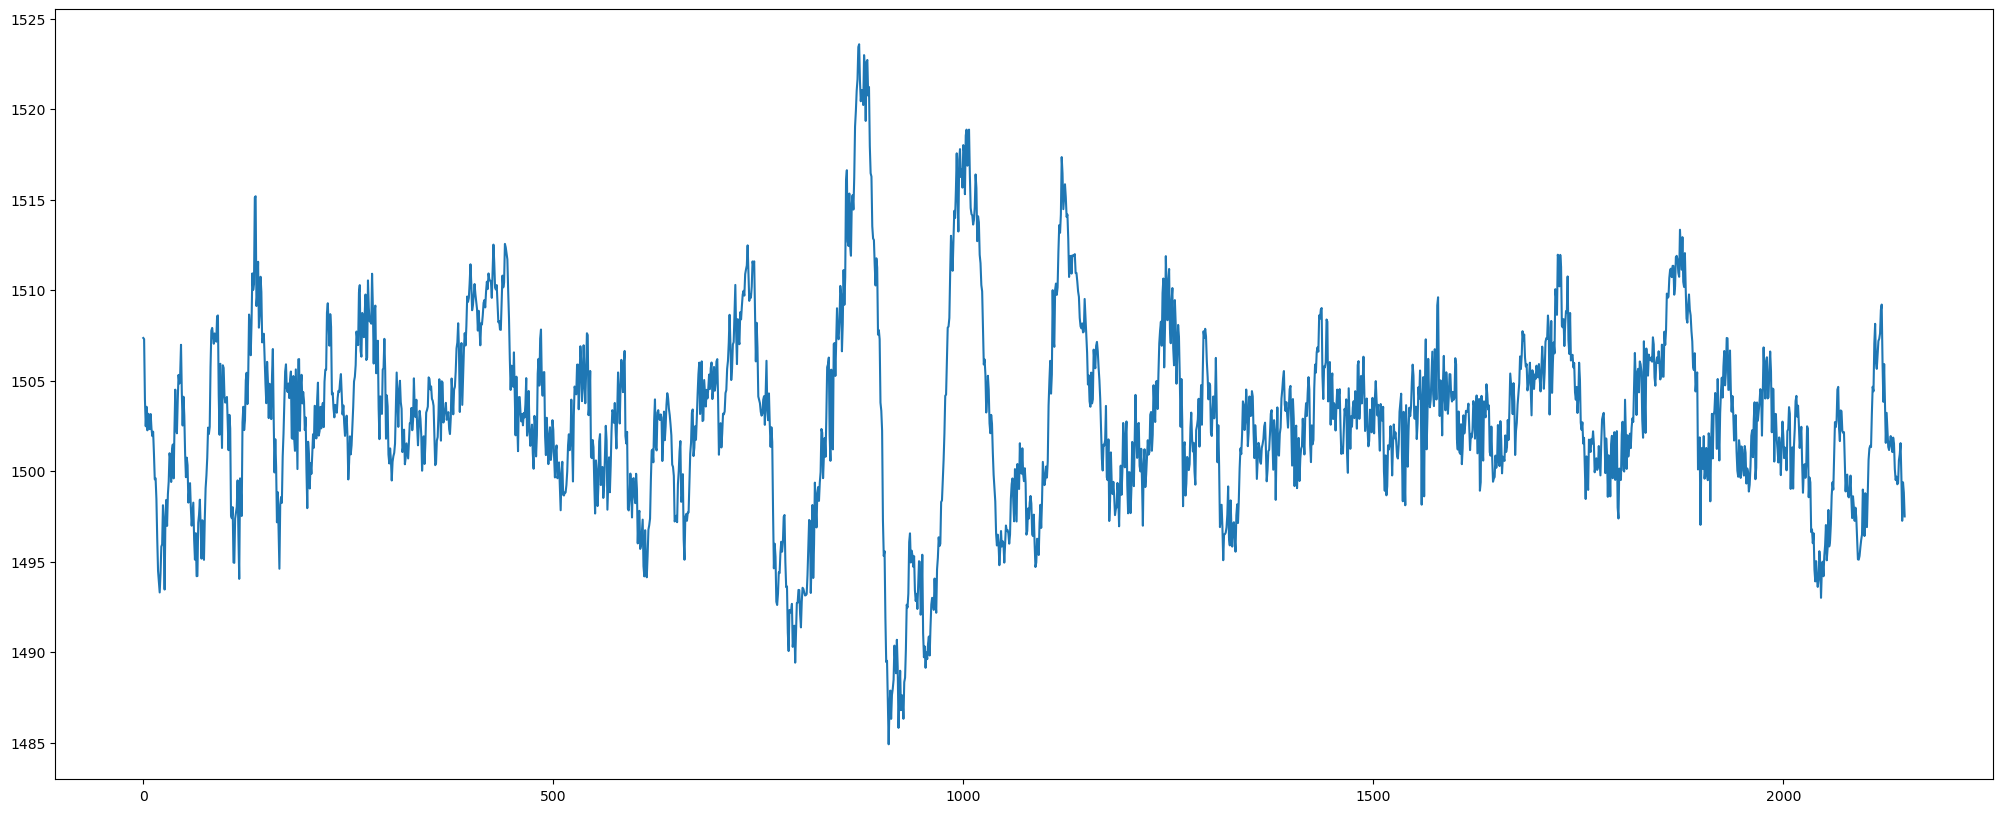

In [103]:
m = (speeds[0][20:] + speeds[1][15:-5] + speeds[1][:-20]) / 3

plt.figure(figsize=(25, 10))
plt.plot(m)

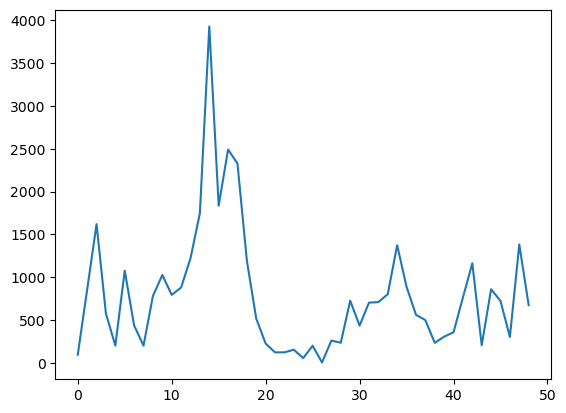

In [108]:
plt.plot(np.abs(np.fft.rfft(m)[1:50]))

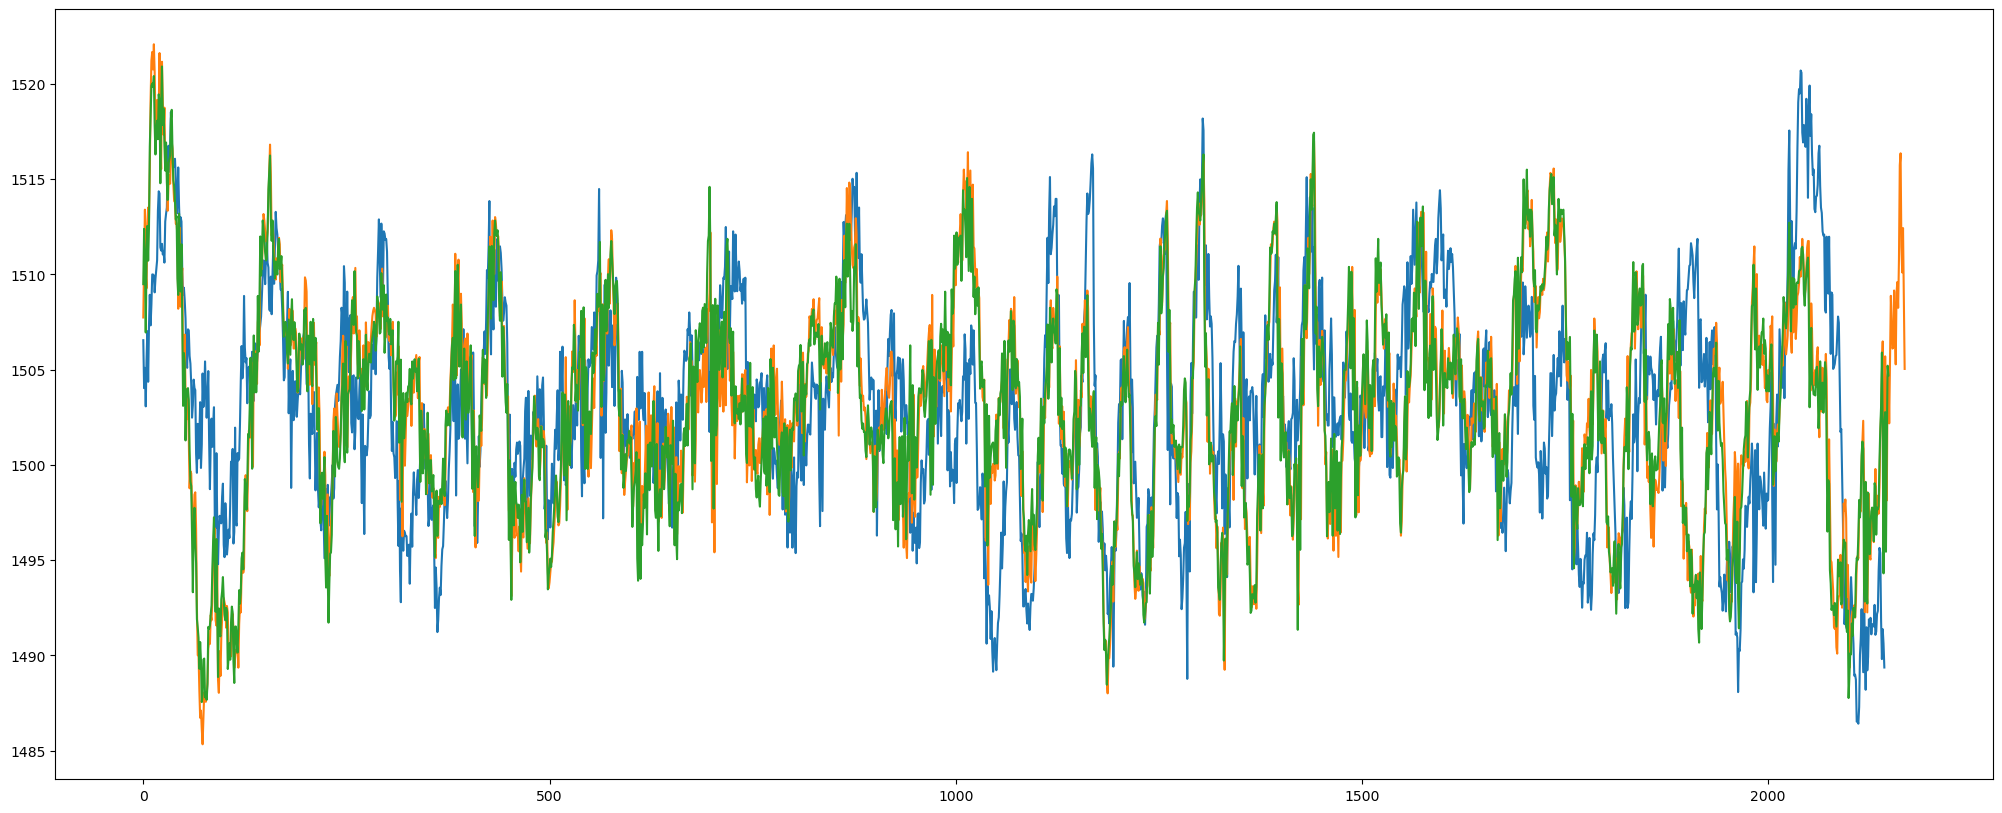

In [93]:
shift = 20
plt.figure(figsize=(25, 10))
plt.plot(speeds[-1][25:])
plt.plot(speeds[-2])
plt.plot(speeds[-3][20:])

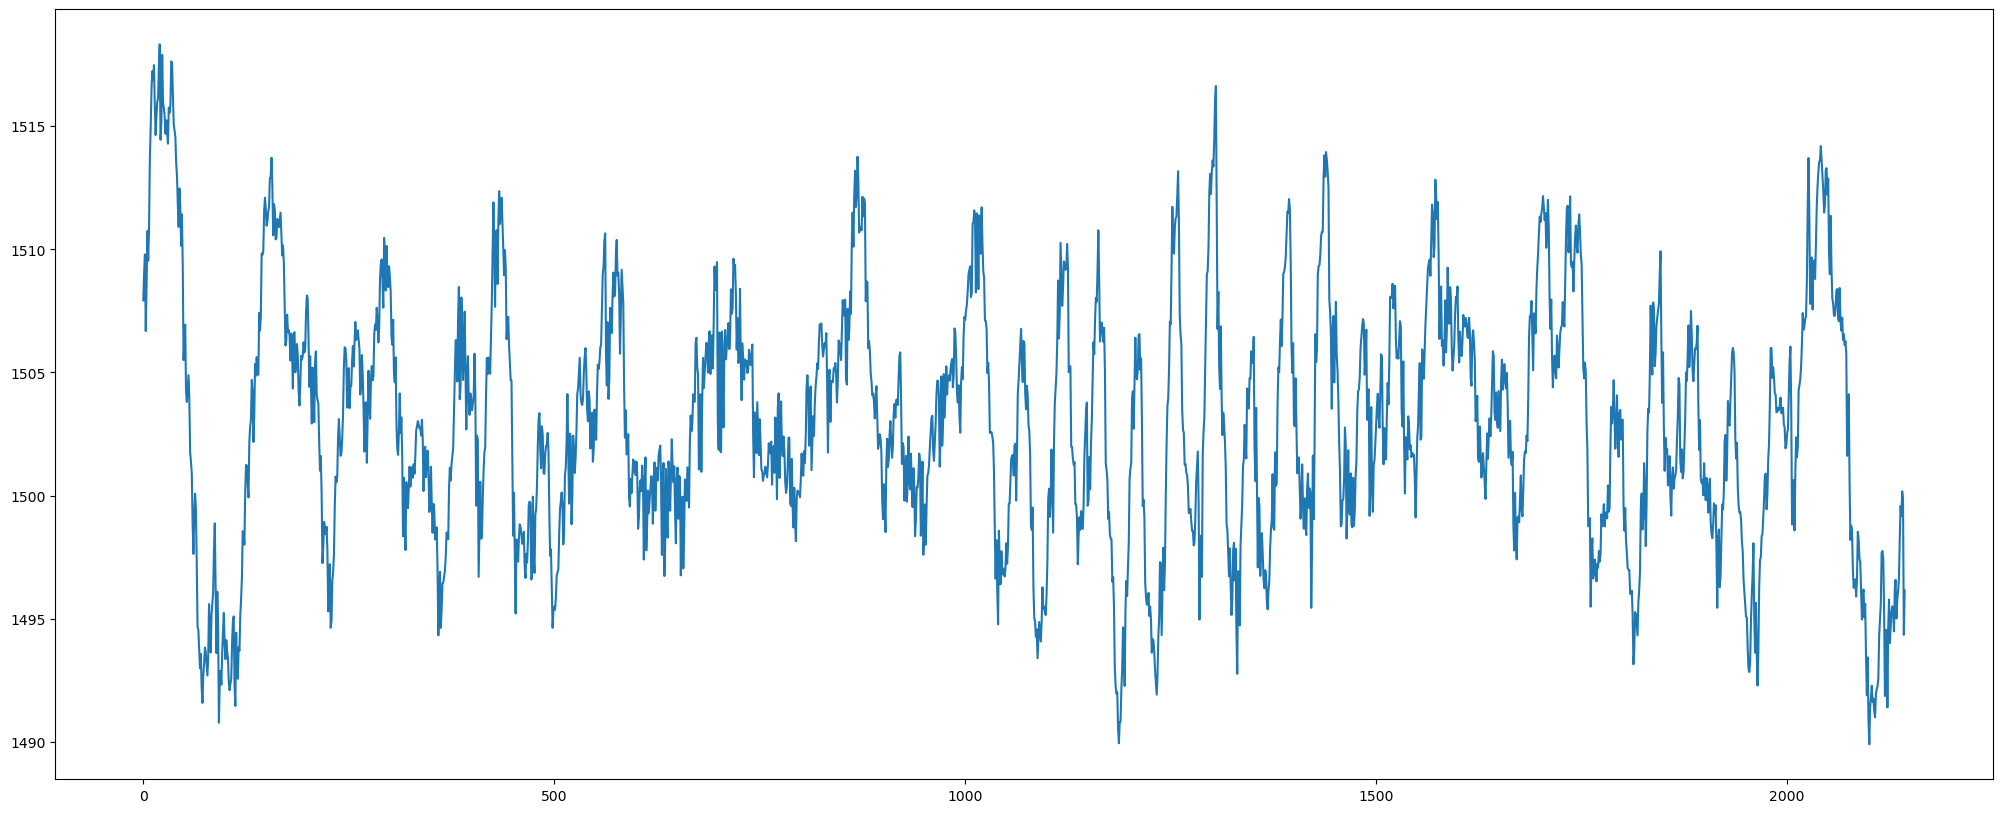

In [102]:
m = (speeds[-1][25:] + speeds[-2][:-25] + speeds[-3][20:-5]) / 3

plt.figure(figsize=(25, 10))
plt.plot(m)

# ARotor scaling checks


In [28]:
data_folder = os.path.join("data")
raw_data_folder = os.path.join(data_folder, "RAW")
processed_data_folder = os.path.join(data_folder, "processed")

df = pd.read_feather(os.path.join(processed_data_folder, "arotor.feather"))
data_processed = df.groupby(["class", "rpm"])
# data_processed.first()


0.00023214033998549493
0.0696591183504773
13.261849666431047

0.00023211339958599232
0.0556525606921805
2.657588116702923


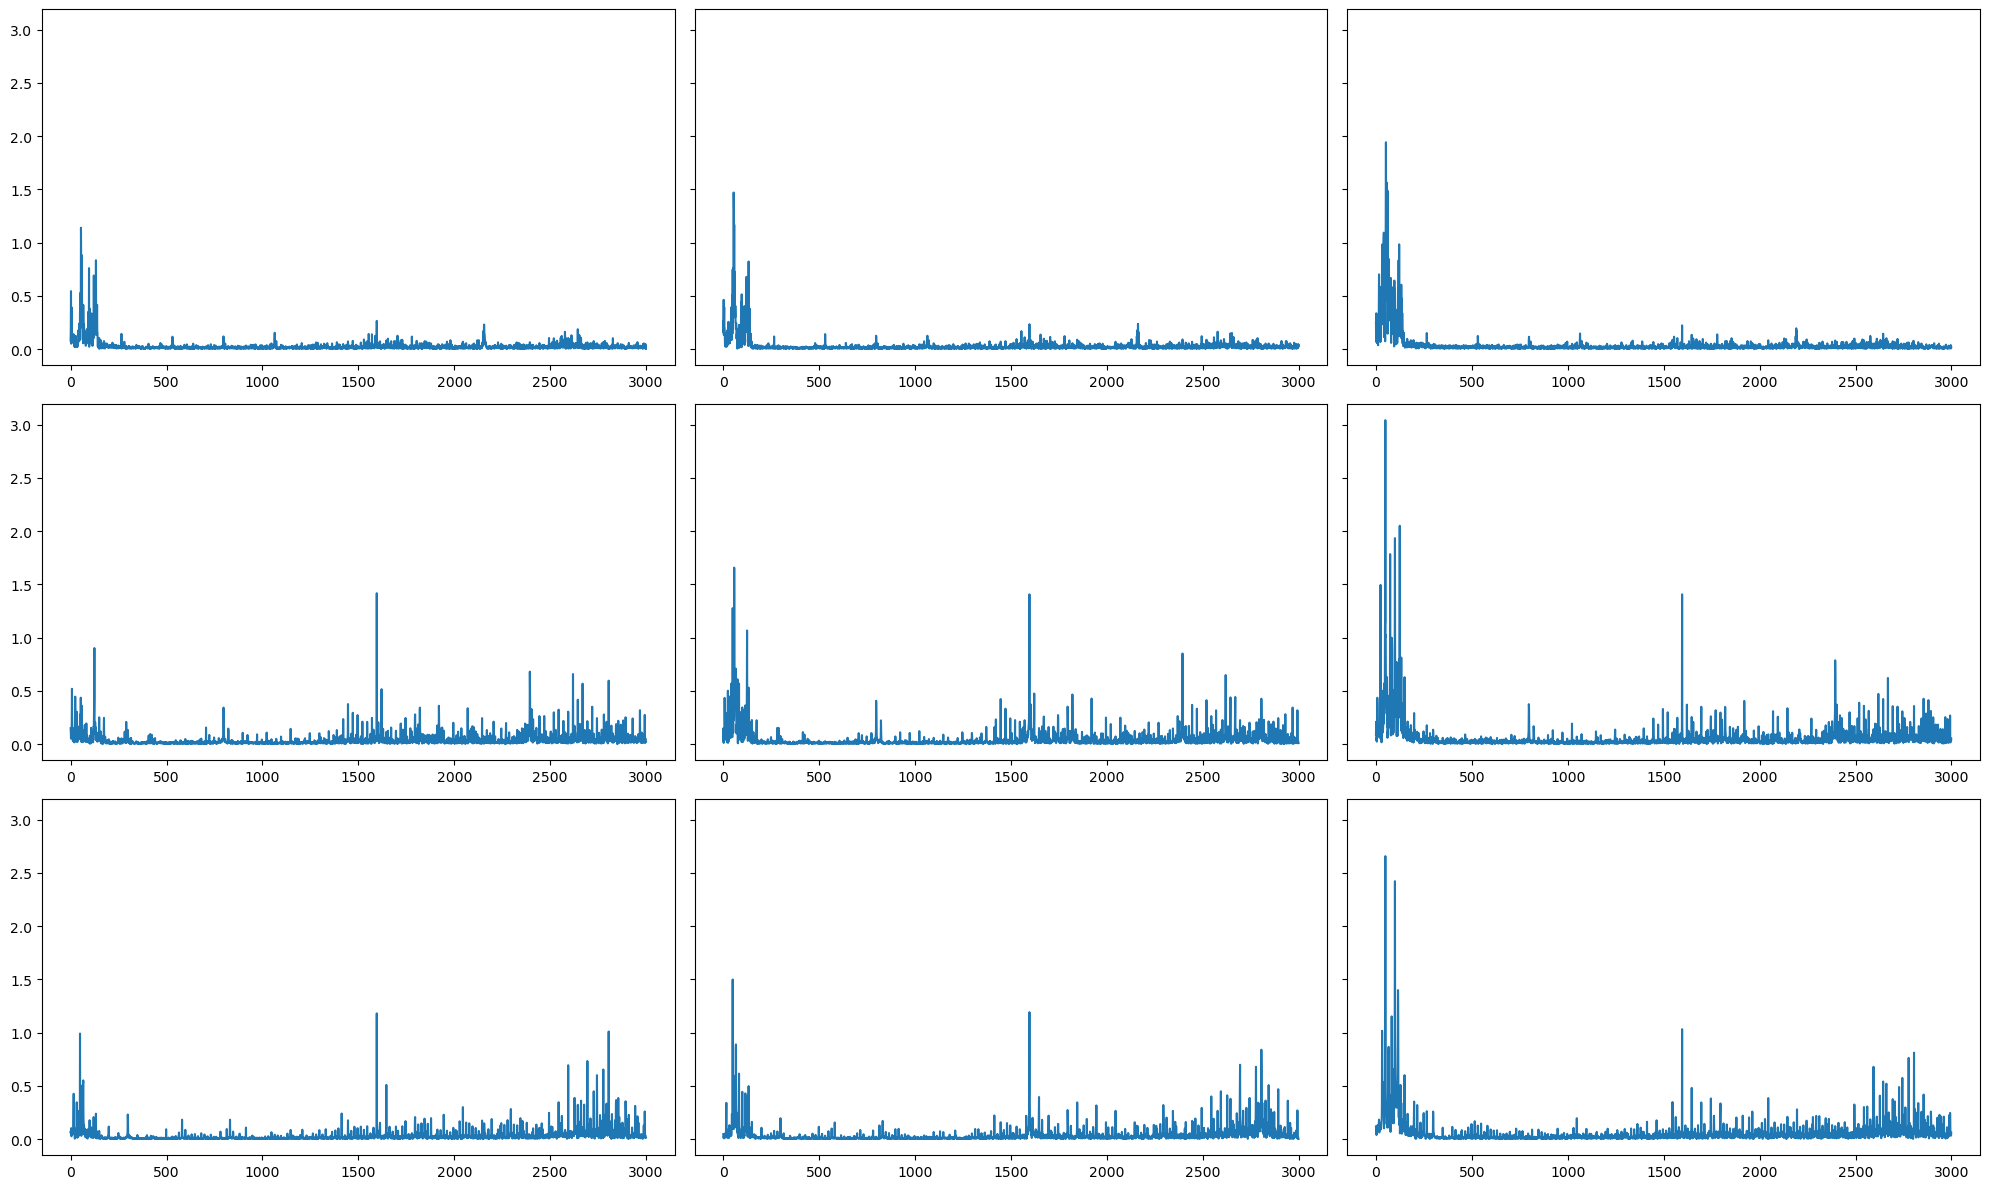

In [14]:
scale = 10

# ....

c0_250 = data_processed.get_group((0, 250))["torque1"][: 4 * 10 * 3012]
c1_250 = data_processed.get_group((1, 250))["torque1"][10 * 3012 : 4 * 10 * 3012]
c9_250 = data_processed.get_group((9, 250))["torque1"][10 * 3012 : 4 * 10 * 3012]

# Scale
c0_250_p25 = np.percentile(c0_250[: 10 * 3012], 25)
c0_250_p75 = np.percentile(c0_250[: 10 * 3012], 75)

c0_250 = c0_250 / (c0_250_p75 - c0_250_p25) * scale
c0_250 = c0_250[10 * 3012 :]

c1_250 = c1_250 / (c0_250_p75 - c0_250_p25) * scale
c9_250 = c9_250 / (c0_250_p75 - c0_250_p25) * scale

# FFT
c0_250 = np.abs(np.fft.rfft(c0_250[:6000], norm="forward"))[1:]
c1_250 = np.abs(np.fft.rfft(c1_250[:6000], norm="forward"))[1:]
c9_250 = np.abs(np.fft.rfft(c9_250[:6000], norm="forward"))[1:]

# Log
c0_250 = np.log1p(c0_250)
c1_250 = np.log1p(c1_250)
c9_250 = np.log1p(c9_250)

# -----

c0_750 = data_processed.get_group((0, 750))["torque1"][: 4 * 10 * 3012]
c1_750 = data_processed.get_group((1, 750))["torque1"][10 * 3012 : 4 * 10 * 3012]
c9_750 = data_processed.get_group((9, 750))["torque1"][10 * 3012 : 4 * 10 * 3012]

# Scale
c0_750_p25 = np.percentile(c0_750[: 10 * 3012], 25)
c0_750_p75 = np.percentile(c0_750[: 10 * 3012], 75)

c0_750 = c0_750 / (c0_750_p75 - c0_750_p25) * scale
c0_750 = c0_750[10 * 3012 :]

c1_750 = c1_750 / (c0_750_p75 - c0_750_p25) * scale
c9_750 = c9_750 / (c0_750_p75 - c0_750_p25) * scale

# FFT
c0_750 = np.abs(np.fft.rfft(c0_750[:6000], norm="forward"))[1:]
c1_750 = np.abs(np.fft.rfft(c1_750[:6000], norm="forward"))[1:]
c9_750 = np.abs(np.fft.rfft(c9_750[:6000], norm="forward"))[1:]

# Log
c0_750 = np.log1p(c0_750)
c1_750 = np.log1p(c1_750)
c9_750 = np.log1p(c9_750)

# -----

c0_1500 = data_processed.get_group((0, 1500))["torque1"][: 4 * 10 * 3012]
c1_1500 = data_processed.get_group((1, 1500))["torque1"][10 * 3012 : 4 * 10 * 3012]
c9_1500 = data_processed.get_group((9, 1500))["torque1"][10 * 3012 : 4 * 10 * 3012]

# Scale
c0_1500_p25 = np.percentile(c0_1500[: 10 * 3012], 25)
c0_1500_p75 = np.percentile(c0_1500[: 10 * 3012], 75)

c0_1500 = c0_1500 / (c0_1500_p75 - c0_1500_p25) * scale
c0_1500 = c0_1500[10 * 3012 :]

c1_1500 = c1_1500 / (c0_1500_p75 - c0_1500_p25) * scale
c9_1500 = c9_1500 / (c0_1500_p75 - c0_1500_p25) * scale

# FFT
c0_1500 = np.abs(np.fft.rfft(c0_1500[:6000], norm="forward"))[1:]
c1_1500 = np.abs(np.fft.rfft(c1_1500[:6000], norm="forward"))[1:]
c9_1500 = np.abs(np.fft.rfft(c9_1500[:6000], norm="forward"))[1:]

print(c9_1500.min())
print(c9_1500.mean())
print(c9_1500.max())

# Log
c0_1500 = np.log1p(c0_1500)
c1_1500 = np.log1p(c1_1500)
c9_1500 = np.log1p(c9_1500)

print()
print(c9_1500.min())
print(c9_1500.mean())
print(c9_1500.max())

# ....

fig, axs = plt.subplots(3, 3, figsize=(20, 12), sharey=True)
axs = axs.flatten()

axs[0].plot(c0_250[:3000])
axs[1].plot(c1_250[:3000])
axs[2].plot(c9_250[:3000])

axs[3].plot(c0_750[:3000])
axs[4].plot(c1_750[:3000])
axs[5].plot(c9_750[:3000])

axs[6].plot(c0_1500[:3000])
axs[7].plot(c1_1500[:3000])
axs[8].plot(c9_1500[:3000])

plt.tight_layout()
plt.show()


## Arotor ridge plots


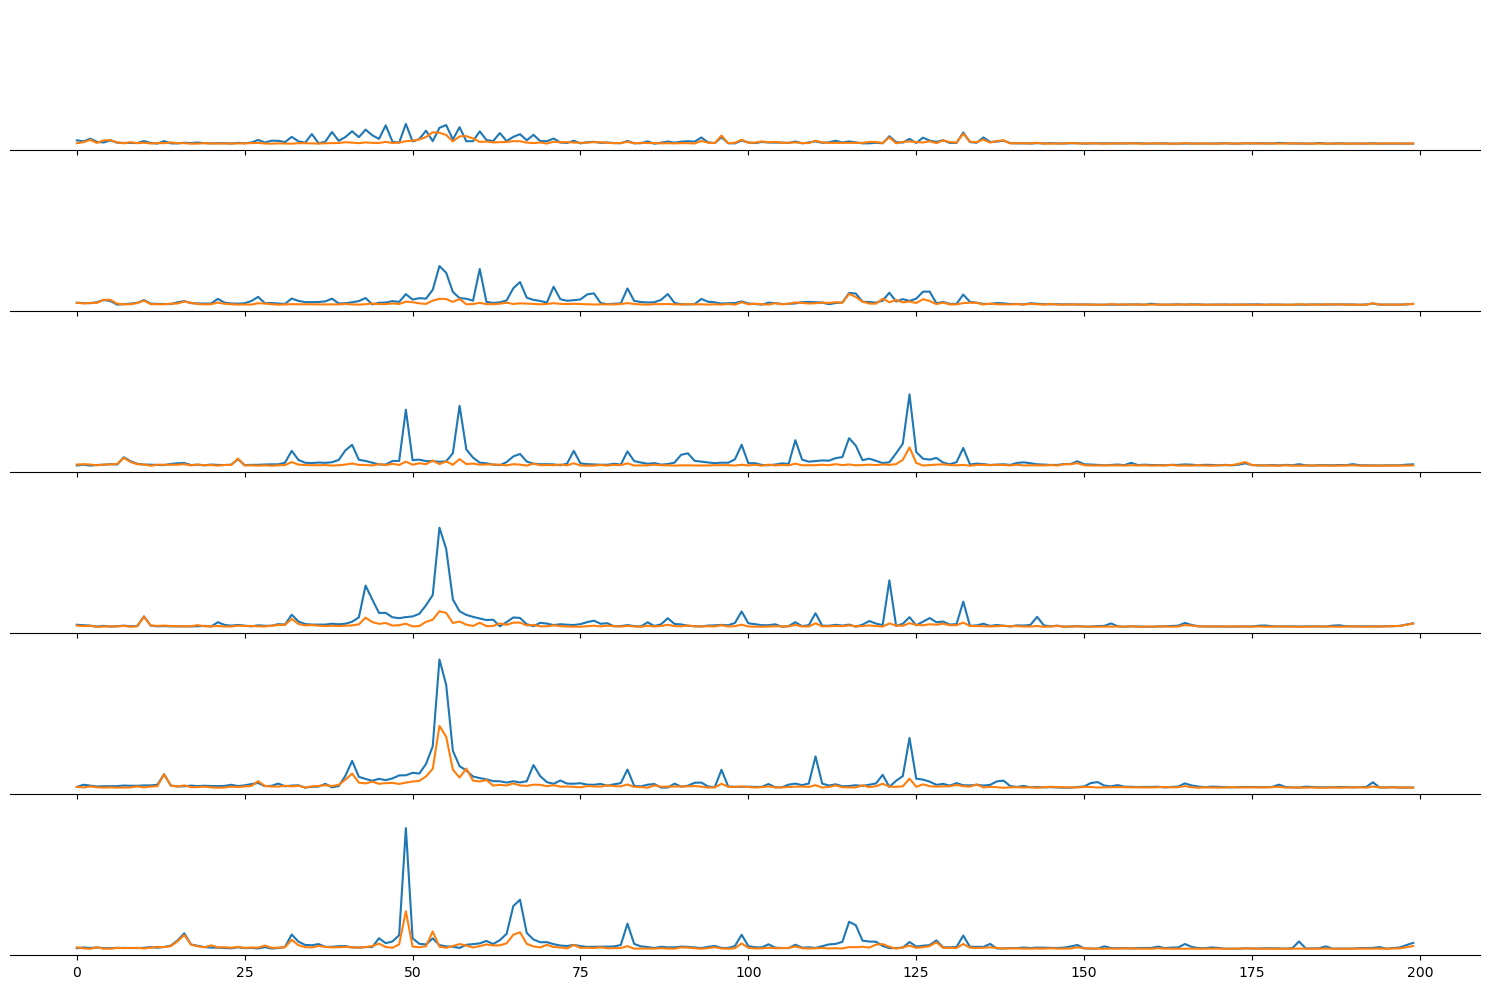

In [39]:
rpms = [250, 500, 750, 1000, 1250, 1500]
data = []
data2 = []

for r in rpms:
    tmp = data_processed.get_group((7, r))["torque1"][10 * 3012 : 10 * 3012 + 6000]

    tmp_healthy = data_processed.get_group((0, r))["torque1"][10 * 3012 : 10 * 3012 + 60000]

    scale = np.percentile(tmp_healthy, 90) - np.percentile(tmp_healthy, 10)

    tmp = tmp[:6000]
    # tmp = np.concatenate([tmp, np.zeros(2192)]) # Pad

    tmp = np.abs(np.fft.rfft(tmp, norm="forward"))[1:]
    # tmp_healthy = np.abs(np.fft.rfft(tmp_healthy[:6000], norm="forward"))[1:]
    for i in range(10):
        healthy_stack = []
        window = tmp_healthy[i * 6000 : (i + 1) * 6000]
        # window = np.concatenate([window, np.zeros(2192)]) # Pad
        healthy_stack.append(np.abs(np.fft.rfft(window, norm="forward"))[1:])
    tmp_healthy = np.array(healthy_stack).mean(axis=0)

    # tmp = np.abs(np.fft.rfft(tmp, norm="forward"))[1:]

    # tmp /= scale
    # tmp_healthy /= scale

    # tmp = np.log1p(tmp)
    # tmp_healthy = np.log1p(tmp_healthy)

    data.append(tmp)
    # data2.append(tmp_scaled)
    data2.append(tmp_healthy)

fig, axs = plt.subplots(6, 1, figsize=(15, 10), sharey=True, sharex=True)
axs = axs.flatten()

L = 200
for i in range(6):
    axs[i].plot(range(L), data[i][:L])
    axs[i].plot(range(L), data2[i][:L])
    axs[i].set(yticks=[])

sns.despine(left=True)

plt.tight_layout()
plt.show()


# ARotor No ML


In [3]:
data_folder = os.path.join("data")
raw_data_folder = os.path.join(data_folder, "RAW")
processed_data_folder = os.path.join(data_folder, "processed")

df = pd.read_feather(os.path.join(processed_data_folder, "arotor.feather"))
data_processed = df.groupby(["class", "rpm"])
data_processed.first()


acc1      acc2      acc3      acc4   torque1    torque2  \
class rpm                                                                 
0     250  -0.192631 -0.154310 -0.248390 -1.462964  0.467285   2.574158   
      500   0.644896  0.379498  0.578659 -5.106649  0.529907   2.779541   
      750  -1.306333 -0.867502 -1.296772  6.191967  0.863159   2.940674   
      1000  1.144464 -0.957802  1.963037 -6.481971  0.713745   3.395691   
      1250  1.859695  2.459741  2.819462  8.170684  0.928223   2.195129   
      1500  2.363398 -2.410662 -3.076066  4.820463  0.983154   4.504700   
1     250   0.123867  0.226329  0.115036  0.809872  0.574585   3.626404   
      500  -0.320203 -0.226030  0.233084  3.211871  0.721436   3.215637   
      750  -0.454418 -2.434444 -0.226311  2.929726  0.979370   3.433533   
      1000  1.837953  1.645023  1.873710  0.695454  0.942261   3.973999   
      1250 -0.030574  1.281953 -7.068002 -4.172929  0.823486   5.983276   
      1500 -0.452490 -2.244975 -2.417454  5.901908  1.275513   6.492004   
2     250  -0.656815 -0.042250 -0.000543  0.220585  0.718872   4.233093   
      500  -0.892220  1.083915 -0.504713 -3.372356  0.686890   2.956543   
      750   0.520973  2.114671  0.022322  0.593647  0.528564   2.277222   
      1000  1.957854 -2.321167  0.739406  6.577379  0.956299   4.353027   
      1250 -2.343807  2.087765 -0.057349 -8.171676  1.175903   2.258301   
      1500  2.825356  3.309805  3.303780  5.004674  1.484863   7.275696   
3     250   0.131988 -0.102686  0.111050  0.586256  0.681763   4.567871   
      500  -0.499174  0.285962 -2.071879 -6.028133  0.647339   3.439941   
      750  -2.109731 -0.602422 -2.597099 -1.236017  0.859253   5.777893   
      1000  1.492453 -3.598573  1.559626  6.761533  1.599854   6.602783   
      1250  6.430590  1.672453  0.716672  7.716622  1.083984   4.371948   
      1500 -3.251070  5.295182  2.049370  9.407150  1.733887  11.101990   
4     250  -0.138294 -0.172928  0.056844  0.122894  0.628174   3.114624   
      500  -0.084499 -2.218986  1.199082  3.143276  0.789062   3.711548   
      750  -0.780271  0.125776 -0.066200 -2.368674  0.457153   3.174438   
      1000 -0.350328  2.129060  0.238454 -0.113558  0.772461   3.171387   
      1250  0.600495 -1.382619  1.035678  9.816699  1.016357   6.296082   
      1500  0.501551  2.198179  5.773494 -5.748140  0.577148   1.304016   
5     250  -0.147630 -0.060830 -0.251683 -1.220955  0.619263   4.122314   
      500  -0.049266  0.510850  0.375737  1.118437  0.814575   4.931335   
      750   0.229753  0.033212  0.645701  1.681509  1.067383   5.260010   
      1000 -0.746236 -1.336383 -0.144468 -0.696520  1.193848   4.830017   
      1250 -0.609944  0.785903 -0.979002  9.357210  0.826050   5.193481   
      1500  0.558283  1.032946 -0.591495 -6.828650  1.117188   5.680237   
6     250  -0.026027 -0.132811 -0.080102  0.732502  0.729004   4.586792   
      500   0.042530 -0.324226 -0.326247  5.272018  1.216797   7.161865   
      750  -1.682221  1.369783 -0.813483  2.078278  0.588623   4.858704   
      1000  0.784575 -2.294260  1.343999  3.375892  1.275513   5.297852   
      1250 -1.850340  2.123054 -0.484973  7.477176  1.898560   9.506226   
      1500  1.392143 -5.755513 -6.346184 -9.007200  0.736694   3.540955   
7     250   0.135599 -0.124934  0.063281 -1.603840  0.529907   2.978516   
      500  -0.336257  0.482896  0.154198  0.879814  0.513306   1.215515   
      750  -1.108389 -0.001123 -3.490685  0.786371  0.727783   1.667480   
      1000 -0.735402  0.993634 -0.283136 -5.940172  1.039307   2.984924   
      1250 -0.736019  0.107701  0.772525  7.436386  1.366211   7.894897   
      1500  2.530245  0.016372  2.709328 -7.160753  0.965210   5.718079   
8     250  -0.318800  0.019366 -0.317958 -1.097480  0.665283   3.689575   
      500   0.332552  0.848249  0.848454  4.039182  0.786499   1.642151   
      750   1.302198  1.113422  2.320287 -1.989344  0.485229   0.005493   
      1000 -0.028591  0.089177 -2.876961 

In [155]:
def get_SQ(rpm, sensor, window_size):
    class_support_windows = []
    class_query_windows = []

    for c in range(10):
        measurement = data_processed.get_group((c, rpm))[sensor]
        L = math.floor(len(measurement) / window_size)
        windows = np.split(measurement[: L * window_size], L)

        support_windows = [windows[i]
                           for i in range(len(windows)) if i % 10 == 0]
        query_windows = [windows[i]
                         for i in range(len(windows)) if i % 10 != 0]

        class_support_windows.append(support_windows)
        class_query_windows.append(query_windows)

    class_support_windows = np.stack(class_support_windows)
    class_query_windows = np.stack(class_query_windows)

    class_support_windows = np.abs(np.fft.rfft(class_support_windows))
    class_query_windows = np.abs(np.fft.rfft(class_query_windows))

    return class_support_windows, class_query_windows


class_support_windows, class_query_windows = get_SQ(250, "acc1", 4096)
print(class_support_windows.shape)
print(class_query_windows.shape)

(10, 11, 2049)
(10, 99, 2049)


In [157]:
def calc_accuracy(class_support_windows, class_query_windows):
    total = 0
    correct = 0

    for i in range(10):  # Query class
        for j in range(class_query_windows.shape[1]):  # Query instance
            for k in range(class_support_windows.shape[1]):  # Support instance
                D = class_support_windows[:, k, :] - np.expand_dims(
                    class_query_windows[i, j, :], 0).repeat(10, axis=0)
                D = np.sqrt(np.sum(np.power(D, 2), axis=1))

                total += 1
                if np.argmin(D) == i:
                    correct += 1

    return correct / total


a = calc_accuracy(class_support_windows, class_query_windows)
print(a)

0.9479338842975207


### 2048


In [ ]:
rpms = [250, 500, 750, 1000, 1250, 1500]
sensors = [
    "acc1",
    "acc2",
    "acc3",
    "acc4",
]
A = []

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, 2048)
        a = calc_accuracy(S, Q)

        print("{:<12} {:<10} {:.2f} %".format(
            sensor, str(rpm) + " rpm:", a * 100))
        A.append(a)

print("Average:", np.mean(A))

acc1         250 rpm:   85.93 %
acc1         500 rpm:   87.76 %
acc1         750 rpm:   82.08 %
acc1         1000 rpm:  91.85 %
acc1         1250 rpm:  89.02 %
acc1         1500 rpm:  89.49 %
acc2         250 rpm:   81.69 %
acc2         500 rpm:   91.22 %
acc2         750 rpm:   89.65 %
acc2         1000 rpm:  96.62 %
acc2         1250 rpm:  92.36 %
acc2         1500 rpm:  92.59 %
acc3         250 rpm:   62.78 %
acc3         500 rpm:   70.81 %
acc3         750 rpm:   77.02 %
acc3         1000 rpm:  89.79 %
acc3         1250 rpm:  85.39 %
acc3         1500 rpm:  90.82 %
acc4         250 rpm:   87.42 %
acc4         500 rpm:   87.78 %
acc4         750 rpm:   96.84 %
acc4         1000 rpm:  93.94 %
acc4         1250 rpm:  95.82 %
acc4         1500 rpm:  88.64 %
Average: 0.8738837235996328


In [ ]:
rpms = [250, 500, 750, 1000, 1250, 1500]
sensors = [
    # "en1acc",
    "en1acc_grad",
    "en2acc_grad",
    "en3acc_grad",
    "en4acc_grad",
    "en5acc_grad",
]
A = []

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, 2408)
        a = calc_accuracy(S, Q)

        print("{:<12} {:<10} {:.2f} %".format(
            sensor, str(rpm) + " rpm:", a * 100))
        A.append(a)

print("Average:", np.mean(A))

en1acc_grad  250 rpm:   70.40 %
en1acc_grad  500 rpm:   93.90 %
en1acc_grad  750 rpm:   99.69 %
en1acc_grad  1000 rpm:  96.11 %
en1acc_grad  1250 rpm:  98.34 %
en1acc_grad  1500 rpm:  98.17 %
en2acc_grad  250 rpm:   61.52 %
en2acc_grad  500 rpm:   87.84 %
en2acc_grad  750 rpm:   97.96 %
en2acc_grad  1000 rpm:  98.14 %
en2acc_grad  1250 rpm:  96.38 %
en2acc_grad  1500 rpm:  96.83 %
en3acc_grad  250 rpm:   54.34 %
en3acc_grad  500 rpm:   95.73 %
en3acc_grad  750 rpm:   97.03 %
en3acc_grad  1000 rpm:  99.76 %
en3acc_grad  1250 rpm:  98.36 %
en3acc_grad  1500 rpm:  95.37 %
en4acc_grad  250 rpm:   68.12 %
en4acc_grad  500 rpm:   94.44 %
en4acc_grad  750 rpm:   95.30 %
en4acc_grad  1000 rpm:  99.66 %
en4acc_grad  1250 rpm:  97.59 %
en4acc_grad  1500 rpm:  95.38 %
en5acc_grad  250 rpm:   70.23 %
en5acc_grad  500 rpm:   84.05 %
en5acc_grad  750 rpm:   89.63 %
en5acc_grad  1000 rpm:  96.27 %
en5acc_grad  1250 rpm:  94.78 %
en5acc_grad  1500 rpm:  95.03 %
Average: 0.9054430670339761


In [ ]:
rpms = [250, 500, 750, 1000, 1250, 1500]
sensors = [
    "en1acc",
    "en2acc",
    "en3acc",
    "en4acc",
    "en5acc",
]
A = []

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, 2408)
        a = calc_accuracy(S, Q)

        print("{:<12} {:<10} {:.2f} %".format(
            sensor, str(rpm) + " rpm:", a * 100))
        A.append(a)

print("Average:", np.mean(A))

en1acc       250 rpm:   73.92 %
en1acc       500 rpm:   87.29 %
en1acc       750 rpm:   99.75 %
en1acc       1000 rpm:  94.70 %
en1acc       1250 rpm:  98.51 %
en1acc       1500 rpm:  93.83 %
en2acc       250 rpm:   83.04 %
en2acc       500 rpm:   95.52 %
en2acc       750 rpm:   99.37 %
en2acc       1000 rpm:  99.16 %
en2acc       1250 rpm:  97.35 %
en2acc       1500 rpm:  93.22 %
en3acc       250 rpm:   71.36 %
en3acc       500 rpm:   96.59 %
en3acc       750 rpm:   98.18 %
en3acc       1000 rpm:  98.96 %
en3acc       1250 rpm:  97.98 %
en3acc       1500 rpm:  94.78 %
en4acc       250 rpm:   74.70 %
en4acc       500 rpm:   93.90 %
en4acc       750 rpm:   94.43 %
en4acc       1000 rpm:  99.77 %
en4acc       1250 rpm:  98.60 %
en4acc       1500 rpm:  97.31 %
en5acc       250 rpm:   73.41 %
en5acc       500 rpm:   92.01 %
en5acc       750 rpm:   93.99 %
en5acc       1000 rpm:  98.56 %
en5acc       1250 rpm:  97.89 %
en5acc       1500 rpm:  95.57 %
Average: 0.9278780284043442


In [ ]:
rpms = [250, 500, 750, 1000, 1250, 1500]
sensors = ["torque1", "torque2"]
A = []

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, 2408)
        a = calc_accuracy(S, Q)

        print("{:<12} {:<10} {:.2f} %".format(
            sensor, str(rpm) + " rpm:", a * 100))
        A.append(a)

print("Average:", np.mean(A))

torque1      250 rpm:   84.39 %
torque1      500 rpm:   94.80 %
torque1      750 rpm:   96.78 %
torque1      1000 rpm:  100.00 %
torque1      1250 rpm:  99.42 %
torque1      1500 rpm:  97.05 %
torque2      250 rpm:   78.72 %
torque2      500 rpm:   87.88 %
torque2      750 rpm:   96.90 %
torque2      1000 rpm:  99.58 %
torque2      1250 rpm:  99.96 %
torque2      1500 rpm:  98.28 %
Average: 0.944783834586466


In [198]:
a = torch.tensor([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
print(a.shape)
a = a.unsqueeze(1).repeat(1, 4, 1, 1)
print(a.shape)
a


torch.Size([2, 2, 3])
torch.Size([2, 4, 2, 3])


tensor([[[[ 1,  2,  3],
          [ 4,  5,  6]],

         [[ 1,  2,  3],
          [ 4,  5,  6]],

         [[ 1,  2,  3],
          [ 4,  5,  6]],

         [[ 1,  2,  3],
          [ 4,  5,  6]]],


        [[[ 7,  8,  9],
          [10, 11, 12]],

         [[ 7,  8,  9],
          [10, 11, 12]],

         [[ 7,  8,  9],
          [10, 11, 12]],

         [[ 7,  8,  9],
          [10, 11, 12]]]])

In [204]:
a = torch.arange(4000).reshape(10, 40, 10)

a = a.reshape(4000, 1)
a.reshape(400, 10)

tensor([[   0,    1,    2,  ...,    7,    8,    9],
        [  10,   11,   12,  ...,   17,   18,   19],
        [  20,   21,   22,  ...,   27,   28,   29],
        ...,
        [3970, 3971, 3972,  ..., 3977, 3978, 3979],
        [3980, 3981, 3982,  ..., 3987, 3988, 3989],
        [3990, 3991, 3992,  ..., 3997, 3998, 3999]])

In [213]:
torch.diag(torch.ones(10)).repeat_interleave(40, dim=0).reshape(10, 40, 10)


tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0., 

### 6000


In [ ]:
rpms = [250, 500, 750, 1000, 1250, 1500]
sensors = [
    "acc1",
    "acc2",
    "acc3",
    "acc4",
]
A = []

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, 6000)
        a = calc_accuracy(S, Q)

        print("{:<12} {:<10} {:.2f} %".format(
            sensor, str(rpm) + " rpm:", a * 100))
        A.append(a)

print("Average:", np.mean(A))

acc1         250 rpm:   97.67 %
acc1         500 rpm:   98.90 %
acc1         750 rpm:   95.90 %
acc1         1000 rpm:  98.82 %
acc1         1250 rpm:  95.06 %
acc1         1500 rpm:  93.43 %
acc2         250 rpm:   97.95 %
acc2         500 rpm:   99.70 %
acc2         750 rpm:   95.15 %
acc2         1000 rpm:  99.51 %
acc2         1250 rpm:  95.37 %
acc2         1500 rpm:  95.32 %
acc3         250 rpm:   86.23 %
acc3         500 rpm:   97.07 %
acc3         750 rpm:   91.21 %
acc3         1000 rpm:  97.16 %
acc3         1250 rpm:  93.54 %
acc3         1500 rpm:  95.41 %
acc4         250 rpm:   99.61 %
acc4         500 rpm:   95.56 %
acc4         750 rpm:   98.54 %
acc4         1000 rpm:  97.29 %
acc4         1250 rpm:  97.85 %
acc4         1500 rpm:  94.59 %
Average: 0.9611940298507462


In [ ]:
rpms = [250, 500, 750, 1000, 1250, 1500]
sensors = [
    "en1acc_grad",
    "en2acc_grad",
    "en3acc_grad",
    "en4acc_grad",
    "en5acc_grad",
]
A = []

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, 6000)
        a = calc_accuracy(S, Q)

        print("{:<12} {:<10} {:.2f} %".format(
            sensor, str(rpm) + " rpm:", a * 100))
        A.append(a)

print("Average:", np.mean(A))

en1acc_grad  250 rpm:   98.17 %
en1acc_grad  500 rpm:   100.00 %
en1acc_grad  750 rpm:   100.00 %
en1acc_grad  1000 rpm:  100.00 %
en1acc_grad  1250 rpm:  98.45 %
en1acc_grad  1500 rpm:  99.50 %
en2acc_grad  250 rpm:   98.81 %
en2acc_grad  500 rpm:   98.47 %
en2acc_grad  750 rpm:   100.00 %
en2acc_grad  1000 rpm:  99.81 %
en2acc_grad  1250 rpm:  98.53 %
en2acc_grad  1500 rpm:  98.32 %
en3acc_grad  250 rpm:   97.20 %
en3acc_grad  500 rpm:   100.00 %
en3acc_grad  750 rpm:   99.98 %
en3acc_grad  1000 rpm:  99.98 %
en3acc_grad  1250 rpm:  98.47 %
en3acc_grad  1500 rpm:  96.21 %
en4acc_grad  250 rpm:   97.11 %
en4acc_grad  500 rpm:   99.70 %
en4acc_grad  750 rpm:   99.27 %
en4acc_grad  1000 rpm:  100.00 %
en4acc_grad  1250 rpm:  98.34 %
en4acc_grad  1500 rpm:  94.98 %
en5acc_grad  250 rpm:   94.61 %
en5acc_grad  500 rpm:   99.87 %
en5acc_grad  750 rpm:   98.75 %
en5acc_grad  1000 rpm:  99.94 %
en5acc_grad  1250 rpm:  98.49 %
en5acc_grad  1500 rpm:  94.94 %
Average: 0.9859701492537313


In [ ]:
rpms = [250, 500, 750, 1000, 1250, 1500]
sensors = ["torque1", "torque2"]
A = []

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, 6000)
        a = calc_accuracy(S, Q)

        print("{:<12} {:<10} {:.2f} %".format(
            sensor, str(rpm) + " rpm:", a * 100))
        A.append(a)

print("Average:", np.mean(A))

torque1      250 rpm:   92.71 %
torque1      500 rpm:   95.65 %
torque1      750 rpm:   96.81 %
torque1      1000 rpm:  100.00 %
torque1      1250 rpm:  98.64 %
torque1      1500 rpm:  97.31 %
torque2      250 rpm:   85.91 %
torque2      500 rpm:   89.18 %
torque2      750 rpm:   96.98 %
torque2      1000 rpm:  100.00 %
torque2      1250 rpm:  98.66 %
torque2      1500 rpm:  98.15 %
Average: 0.9583333333333334


### 6000 (w/ Hz dropping)


#### Acc high pass filter


In [201]:
rpms = [750]
sensors = [
    "acc1",
    "acc2",
    "acc3",
    "acc4",
]
A = []

window_size = 723 * 8
bin_size = 3012 / 2 / (window_size / 2)

print("Bin size", round(bin_size, 3), "Hz")
print("Window size", window_size, round(window_size / 3012, 3), "s")

print()
print("{:<12} {:<10} {:<15} {:>15} {:>15} {:>10} %".format(
    "sensor", "rpm", "Q shape", "Min Hz", "Max Hz", "Accuracy"))
print()

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, window_size)
        S_orig = S
        a = calc_accuracy(S, Q)
        print(
            "{:<12} {:<10} {:<15} {:>12.2f} Hz {:>12.2f} Hz {:>10.2f} %".format(
                sensor, str(
                    rpm) + " rpm:", str(Q.shape), 0, (S_orig.shape[-1] - 1) * bin_size, a * 100
            )
        )

        step = 500
        for i in range(1, 6):
            S = S[:, :, step:]
            Q = Q[:, :, step:]
            a = calc_accuracy(S, Q)
            print(
                "{:<12} {:<10} {:<15} {:>12.2f} Hz {:>12.2f} Hz {:>10.2f} %".format(
                    "-", "-", str(Q.shape), i * step *
                    bin_size, (S_orig.shape[-1] - 1) * bin_size, a * 100
                )
            )
    print()

Bin size 0.521 Hz
Window size 5784 1.92 s

sensor       rpm        Q shape                  Min Hz          Max Hz   Accuracy %

acc1         750 rpm:   (10, 70, 2893)          0.00 Hz      1506.00 Hz      95.55 %
-            -          (10, 70, 2393)        260.37 Hz      1506.00 Hz      92.77 %
-            -          (10, 70, 1893)        520.75 Hz      1506.00 Hz      90.93 %
-            -          (10, 70, 1393)        781.12 Hz      1506.00 Hz      89.16 %
-            -          (10, 70, 893)        1041.49 Hz      1506.00 Hz      85.14 %
-            -          (10, 70, 393)        1301.87 Hz      1506.00 Hz      82.34 %

acc2         750 rpm:   (10, 70, 2893)          0.00 Hz      1506.00 Hz      94.79 %
-            -          (10, 70, 2393)        260.37 Hz      1506.00 Hz      91.59 %
-            -          (10, 70, 1893)        520.75 Hz      1506.00 Hz      89.12 %
-            -          (10, 70, 1393)        781.12 Hz      1506.00 Hz      89.09 %
-            -      

#### Acc low pass filter


In [200]:
rpms = [750]
sensors = [
    "acc1",
    "acc2",
    "acc3",
    "acc4",
]
A = []

window_size = 723 * 8
bin_size = 3012 / 2 / (window_size / 2)

print("Bin size", round(bin_size, 3), "Hz")
print("Window size", window_size, round(window_size / 3012, 3), "s")

print()
print("{:<12} {:<10} {:<15} {:>15} {:>15} {:>10} %".format(
    "sensor", "rpm", "Q shape", "Min Hz", "Max Hz", "Accuracy"))
print()

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, window_size)
        S_orig = S
        a = calc_accuracy(S, Q)
        print(
            "{:<12} {:<10} {:<15} {:>12.2f} Hz {:>12.2f} Hz {:>10.2f} %".format(
                sensor, str(
                    rpm) + " rpm:", str(Q.shape), 0, (S_orig.shape[-1] - 1) * bin_size, a * 100
            )
        )

        step = 500
        for i in range(1, 6):
            S = S[:, :, :-step]
            Q = Q[:, :, :-step]
            a = calc_accuracy(S, Q)
            print(
                "{:<12} {:<10} {:<15} {:>12.2f} Hz {:>12.2f} Hz {:>10.2f} %".format(
                    "-", "-", str(Q.shape), 0, (S_orig.shape[-1] -
                                                i * step) * bin_size, a * 100
                )
            )
    print()

Bin size 0.521 Hz
Window size 5784 1.92 s

sensor       rpm        Q shape                  Min Hz          Max Hz   Accuracy %

acc1         750 rpm:   (10, 70, 2893)          0.00 Hz      1506.00 Hz      95.55 %
-            -          (10, 70, 2393)          0.00 Hz      1246.15 Hz      95.52 %
-            -          (10, 70, 1893)          0.00 Hz       985.77 Hz      95.27 %
-            -          (10, 70, 1393)          0.00 Hz       725.40 Hz      95.77 %
-            -          (10, 70, 893)           0.00 Hz       465.03 Hz      92.75 %
-            -          (10, 70, 393)           0.00 Hz       204.65 Hz      93.75 %

acc2         750 rpm:   (10, 70, 2893)          0.00 Hz      1506.00 Hz      94.79 %
-            -          (10, 70, 2393)          0.00 Hz      1246.15 Hz      94.77 %
-            -          (10, 70, 1893)          0.00 Hz       985.77 Hz      94.80 %
-            -          (10, 70, 1393)          0.00 Hz       725.40 Hz      94.82 %
-            -      

#### Torque high pass filter


In [228]:
rpms = [750]
sensors = [
    "torque1",
    "torque2",
]
A = []

window_size = 723 * 8
bin_size = 3012 / 2 / (window_size / 2)

print("Bin size", round(bin_size, 3), "Hz")
print("Window size", window_size, round(window_size / 3012, 3), "s")

print()
print("{:<12} {:<10} {:<15} {:>15} {:>15} {:>10} %".format(
    "sensor", "rpm", "Q shape", "Min Hz", "Max Hz", "Accuracy"))
print()

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, window_size)
        S_orig = S
        a = calc_accuracy(S, Q)
        print(
            "{:<12} {:<10} {:<15} {:>12.2f} Hz {:>12.2f} Hz {:>10.2f} %".format(
                sensor, str(
                    rpm) + " rpm:", str(Q.shape), 0, (S_orig.shape[-1] - 1) * bin_size, a * 100
            )
        )

        step = 500
        for i in range(1, 6):
            S = S[:, :, step:]
            Q = Q[:, :, step:]
            a = calc_accuracy(S, Q)
            print(
                "{:<12} {:<10} {:<15} {:>12.2f} Hz {:>12.2f} Hz {:>10.2f} %".format(
                    "-", "-", str(Q.shape), i * step *
                    bin_size, (S_orig.shape[-1] - 1) * bin_size, a * 100
                )
            )
    print()

Bin size 0.521 Hz
Window size 5784 1.92 s

sensor       rpm        Q shape                  Min Hz          Max Hz   Accuracy %

torque1      750 rpm:   (10, 70, 2893)          0.00 Hz      1506.00 Hz      97.27 %
-            -          (10, 70, 2393)        260.37 Hz      1506.00 Hz      99.93 %
-            -          (10, 70, 1893)        520.75 Hz      1506.00 Hz      99.93 %
-            -          (10, 70, 1393)        781.12 Hz      1506.00 Hz      99.84 %
-            -          (10, 70, 893)        1041.49 Hz      1506.00 Hz      99.55 %
-            -          (10, 70, 393)        1301.87 Hz      1506.00 Hz      97.00 %

torque2      750 rpm:   (10, 70, 2893)          0.00 Hz      1506.00 Hz      97.55 %
-            -          (10, 70, 2393)        260.37 Hz      1506.00 Hz      96.11 %
-            -          (10, 70, 1893)        520.75 Hz      1506.00 Hz      76.48 %
-            -          (10, 70, 1393)        781.12 Hz      1506.00 Hz      54.27 %
-            -      

#### Torque low pass filter


In [205]:
rpms = [750]
sensors = [
    "torque1",
    "torque1",
]
A = []

window_size = 723 * 8
bin_size = 3012 / 2 / (window_size / 2)

print("Bin size", round(bin_size, 3), "Hz")
print("Window size", window_size, round(window_size / 3012, 3), "s")

print()
print("{:<12} {:<10} {:<15} {:>15} {:>15} {:>10} %".format(
    "sensor", "rpm", "Q shape", "Min Hz", "Max Hz", "Accuracy"))
print()

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, window_size)
        S_orig = S
        a = calc_accuracy(S, Q)
        print(
            "{:<12} {:<10} {:<15} {:>12.2f} Hz {:>12.2f} Hz {:>10.2f} %".format(
                sensor, str(
                    rpm) + " rpm:", str(Q.shape), 0, (S_orig.shape[-1] - 1) * bin_size, a * 100
            )
        )

        step = 500
        for i in range(1, 6):
            S = S[:, :, :-step]
            Q = Q[:, :, :-step]
            a = calc_accuracy(S, Q)
            print(
                "{:<12} {:<10} {:<15} {:>12.2f} Hz {:>12.2f} Hz {:>10.2f} %".format(
                    "-", "-", str(Q.shape), 0, (S_orig.shape[-1] -
                                                i * step) * bin_size, a * 100
                )
            )
    print()

Bin size 0.521 Hz
Window size 5784 1.92 s

sensor       rpm        Q shape                  Min Hz          Max Hz   Accuracy %

torque1      750 rpm:   (10, 70, 2893)          0.00 Hz      1506.00 Hz      97.27 %
-            -          (10, 70, 2393)          0.00 Hz      1246.15 Hz      97.20 %
-            -          (10, 70, 1893)          0.00 Hz       985.77 Hz      97.14 %
-            -          (10, 70, 1393)          0.00 Hz       725.40 Hz      97.07 %
-            -          (10, 70, 893)           0.00 Hz       465.03 Hz      97.07 %
-            -          (10, 70, 393)           0.00 Hz       204.65 Hz      97.05 %

torque1      750 rpm:   (10, 70, 2893)          0.00 Hz      1506.00 Hz      97.27 %
-            -          (10, 70, 2393)          0.00 Hz      1246.15 Hz      97.20 %
-            -          (10, 70, 1893)          0.00 Hz       985.77 Hz      97.14 %
-            -          (10, 70, 1393)          0.00 Hz       725.40 Hz      97.07 %
-            -      

#### Enc high pass filter


In [204]:
rpms = [250]
sensors = [
    "en1acc_grad",
    "en2acc_grad",
    "en3acc_grad",
    "en4acc_grad",
    "en5acc_grad",
]
A = []

window_size = 361 * 8
bin_size = 3012 / 2 / (window_size / 2)

print("Bin size", round(bin_size, 3), "Hz")
print("Window size", window_size, round(window_size / 3012, 3), "s")

print()
print("{:<12} {:<10} {:<15} {:>15} {:>15} {:>10} %".format(
    "sensor", "rpm", "Q shape", "Min Hz", "Max Hz", "Accuracy"))
print()

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, window_size)
        S_orig = S
        a = calc_accuracy(S, Q)
        print(
            "{:<12} {:<10} {:<15} {:>12.2f} Hz {:>12.2f} Hz {:>10.2f} %".format(
                sensor, str(
                    rpm) + " rpm:", str(Q.shape), 0, (S_orig.shape[-1] - 1) * bin_size, a * 100
            )
        )

        step = 200
        for i in range(1, 6):
            S = S[:, :, step:]
            Q = Q[:, :, step:]
            a = calc_accuracy(S, Q)
            print(
                "{:<12} {:<10} {:<15} {:>12.2f} Hz {:>12.2f} Hz {:>10.2f} %".format(
                    "-", "-", str(Q.shape), i * step *
                    bin_size, (S_orig.shape[-1] - 1) * bin_size, a * 100
                )
            )
    print()

Bin size 1.043 Hz
Window size 2888 0.959 s

sensor       rpm        Q shape                  Min Hz          Max Hz   Accuracy %

en1acc_grad  250 rpm:   (10, 140, 1445)         0.00 Hz      1506.00 Hz      84.51 %
-            -          (10, 140, 1245)       208.59 Hz      1506.00 Hz      80.08 %
-            -          (10, 140, 1045)       417.17 Hz      1506.00 Hz      79.44 %
-            -          (10, 140, 845)        625.76 Hz      1506.00 Hz      78.67 %
-            -          (10, 140, 645)        834.35 Hz      1506.00 Hz      74.33 %
-            -          (10, 140, 445)       1042.94 Hz      1506.00 Hz      69.44 %

en2acc_grad  250 rpm:   (10, 140, 1445)         0.00 Hz      1506.00 Hz      84.48 %
-            -          (10, 140, 1245)       208.59 Hz      1506.00 Hz      81.15 %
-            -          (10, 140, 1045)       417.17 Hz      1506.00 Hz      76.23 %
-            -          (10, 140, 845)        625.76 Hz      1506.00 Hz      74.59 %
-            -     

#### Enc low pass filter


In [206]:
rpms = [250]
sensors = [
    "en1acc_grad",
    "en2acc_grad",
    "en3acc_grad",
    "en4acc_grad",
    "en5acc_grad",
]
A = []

window_size = 361 * 8
bin_size = 3012 / 2 / (window_size / 2)

print("Bin size", round(bin_size, 3), "Hz")
print("Window size", window_size, round(window_size / 3012, 3), "s")

print()
print("{:<12} {:<10} {:<15} {:>15} {:>15} {:>10} %".format(
    "sensor", "rpm", "Q shape", "Min Hz", "Max Hz", "Accuracy"))
print()

for sensor in sensors:
    for rpm in rpms:
        S, Q = get_SQ(rpm, sensor, window_size)
        S_orig = S
        a = calc_accuracy(S, Q)
        print(
            "{:<12} {:<10} {:<15} {:>12.2f} Hz {:>12.2f} Hz {:>10.2f} %".format(
                sensor, str(
                    rpm) + " rpm:", str(Q.shape), 0, (S_orig.shape[-1] - 1) * bin_size, a * 100
            )
        )

        step = 200
        for i in range(1, 6):
            S = S[:, :, :-step]
            Q = Q[:, :, :-step]
            a = calc_accuracy(S, Q)
            print(
                "{:<12} {:<10} {:<15} {:>12.2f} Hz {:>12.2f} Hz {:>10.2f} %".format(
                    "-", "-", str(Q.shape), 0, (S_orig.shape[-1] -
                                                i * step) * bin_size, a * 100
                )
            )
    print()

Bin size 1.043 Hz
Window size 2888 0.959 s

sensor       rpm        Q shape                  Min Hz          Max Hz   Accuracy %

en1acc_grad  250 rpm:   (10, 140, 1445)         0.00 Hz      1506.00 Hz      84.51 %
-            -          (10, 140, 1245)         0.00 Hz      1298.46 Hz      84.50 %
-            -          (10, 140, 1045)         0.00 Hz      1089.87 Hz      84.15 %
-            -          (10, 140, 845)          0.00 Hz       881.28 Hz      82.62 %
-            -          (10, 140, 645)          0.00 Hz       672.69 Hz      83.14 %
-            -          (10, 140, 445)          0.00 Hz       464.11 Hz      79.52 %

en2acc_grad  250 rpm:   (10, 140, 1445)         0.00 Hz      1506.00 Hz      84.48 %
-            -          (10, 140, 1245)         0.00 Hz      1298.46 Hz      84.46 %
-            -          (10, 140, 1045)         0.00 Hz      1089.87 Hz      84.34 %
-            -          (10, 140, 845)          0.00 Hz       881.28 Hz      83.88 %
-            -     

# ARotor scaling and masking


In [86]:
data_folder = os.path.join("data")
raw_data_folder = os.path.join(data_folder, "RAW")
processed_data_folder = os.path.join(data_folder, "processed")

df = pd.read_feather(os.path.join(processed_data_folder, "arotor.feather"))


In [87]:
sensors = ["acc1", "acc2"]
# rpms = [500]
rpms = [750, 1000, 1250]
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

rotation_len_map = {
    250: 2169,
    500: int(2048 / 4),  # FIXME
    # 500: 1084,
    750: 723,
    1000: 542,
    1250: 434,
    1500: 361,
}


def fewshot_data_selection(data, sensors, rpm, classes):
    selected_data = data.loc[:, sensors + ["rpm", "class"]]
    selected_data = selected_data[(selected_data["rpm"].isin(rpm)) & (
        selected_data["class"].isin(classes))]

    return selected_data


data = fewshot_data_selection(df, sensors, rpms, classes)

---


In [88]:
head_len = 3012 * 10

train_grouped = data.groupby(["class", "rpm"])

train_head = train_grouped.head(head_len)
train_head = train_head[train_head["class"] == 0]
train_tail = train_grouped.tail(int((len(data) / (10 * len(sensors))) - head_len))

train_head


,acc1,acc2,rpm,class
24400892,1.144464,-0.957802,1000,0
24400893,0.464372,-2.405367,1000,0
24400894,0.831483,-0.618308,1000,0
24400895,1.670395,0.899798,1000,0
24400896,2.222672,-0.236246,1000,0
...,...,...,...,...
25335003,-0.070485,2.457140,1250,0
25335004,-0.245246,1.018201,1250,0
25335005,0.548983,-1.586158,1250,0
25335006,-1.444608,-0.260739,1250,0


In [89]:
# Scaling #

scale = {}
train_head_grouped = train_head.groupby(["class", "rpm"], group_keys=False)
for n, g in train_head_grouped:
    p25 = g[sensors].quantile(0.25)
    p75 = g[sensors].quantile(0.75)

    scale[n[1]] = p75 - p25

print(scale)


def scale_group(group_data):
    group_data[sensors] = group_data[sensors] / scale[group_data.name[1]]

    return group_data


train_head = train_head_grouped.apply(scale_group)
train_head

# train_head

{750: acc1    1.124130
acc2    1.438027
dtype: float64, 1000: acc1    1.652980
acc2    1.866197
dtype: float64, 1250: acc1    1.983165
acc2    2.344457
dtype: float64}


,acc1,acc2,rpm,class
24400892,0.692364,-0.513237,1000,0
24400893,0.280930,-1.288913,1000,0
24400894,0.503021,-0.331320,1000,0
24400895,1.010536,0.482156,1000,0
24400896,1.344645,-0.126592,1000,0
...,...,...,...,...
25335003,-0.035542,1.048064,1250,0
25335004,-0.123664,0.434301,1250,0
25335005,0.276822,-0.676556,1250,0
25335006,-0.728436,-0.111215,1250,0


In [90]:
# Masking #

masks = {}


def create_overlapping_windows(dataframe, window_size, overlap_pct):
    num_rows = dataframe.shape[0]
    stride = int(window_size * (1 - overlap_pct))
    num_windows = (num_rows - window_size) // stride + 1

    start_indices = np.arange(num_windows) * stride
    end_indices = start_indices + window_size

    windows = [dataframe.iloc[start:end]
               for start, end in zip(start_indices, end_indices)]

    return windows


for n, g in train_head.groupby(["class", "rpm"]):
    windows = create_overlapping_windows(g, 6000, 0.95)

    for sensor in sensors:
        sensor_windows = torch.tensor(
            np.array([window[sensor].to_numpy() for window in windows]))

        fft_windows = torch.abs(torch.fft.rfft(sensor_windows))
        mask = fft_windows.mean(dim=0)

        masks[(n[1], sensor)] = mask

print(masks.keys())

dict_keys([(750, 'acc1'), (750, 'acc2'), (1000, 'acc1'), (1000, 'acc2'), (1250, 'acc1'), (1250, 'acc2')])


---


In [235]:
rots = 4  # config rots
head_len = 3012 * 10
max_window_len = rotation_len_map[250]  # 1 rot at 250 rpm

print(len(data))

head = data.groupby(["rpm", "class"]).head(head_len)
tail = data.groupby(["rpm", "class"]).tail(
    int((len(data) / (len(classes) * len(rpms))) - head_len)
)  # 10 for num classes, 2 for num rpm

print(len(head))
print(len(tail))

# Convert to long format to include sensor in groupby
head_long = pd.melt(
    head, id_vars=["rpm", "class"], value_vars=sensors, var_name="sensor")
head_grouped = head_long.groupby(["rpm", "class", "sensor"])

4519480
301200
4218280


214
(500, 0, 'acc1') (214, 1025)


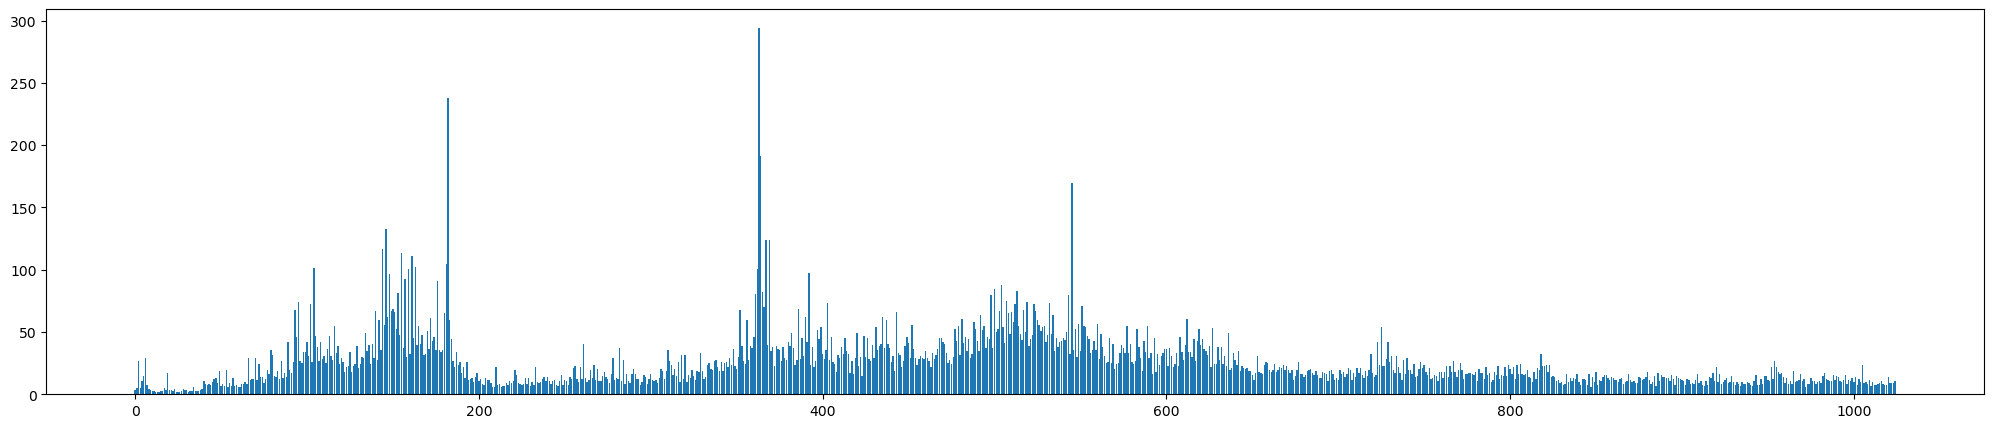

214 1025


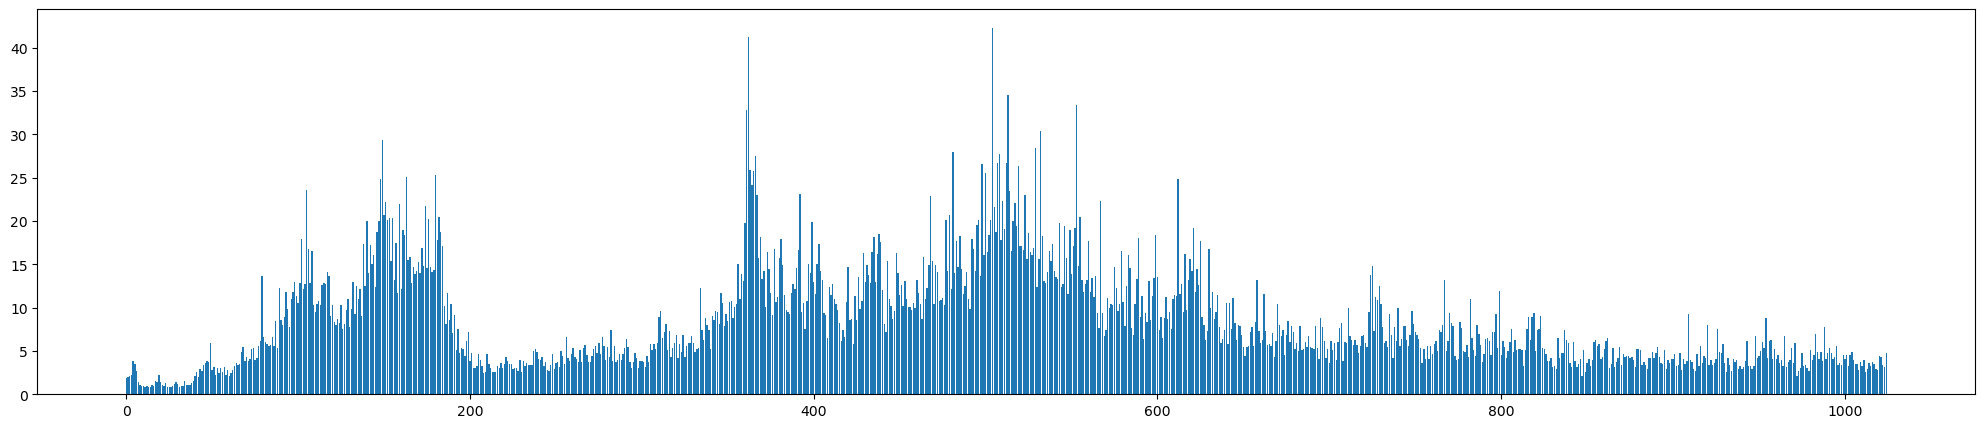

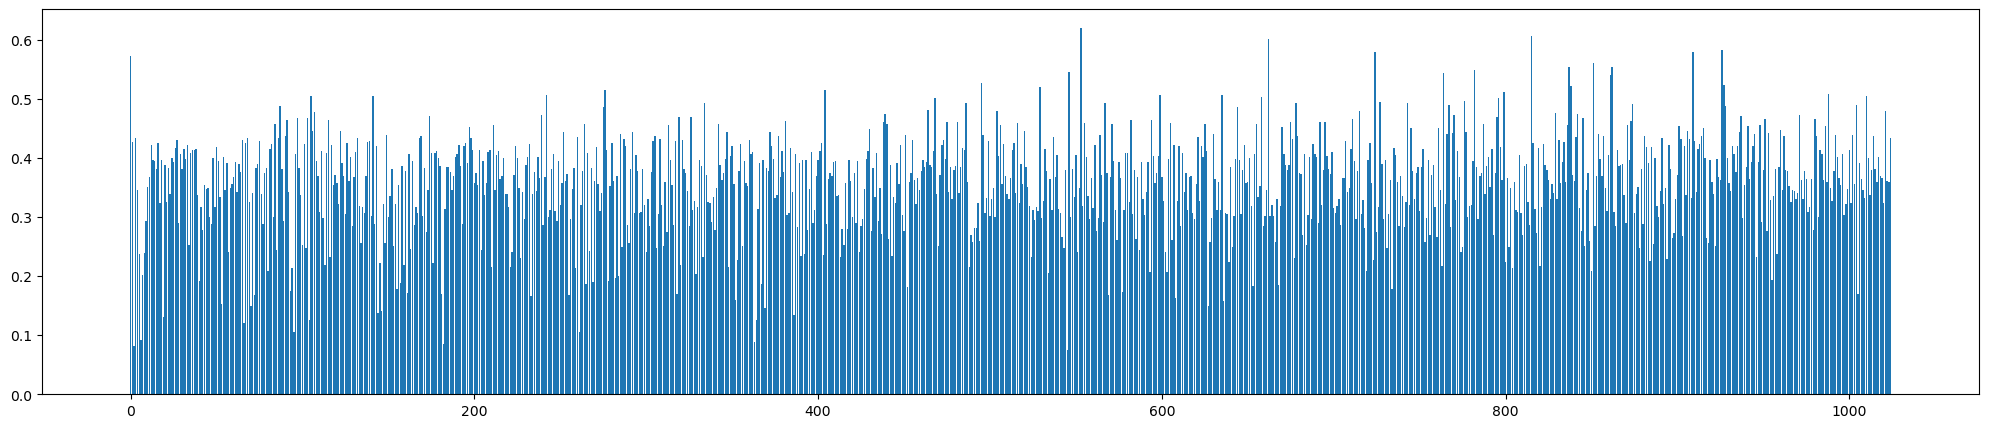

In [242]:
def strided_window_idxs(window_len, stride, window_num):
    return np.concatenate([np.r_[i * stride: i * stride + window_len] for i in range(window_num)])


stride = 100
window_num = math.floor((head_len - max_window_len * rots) / stride)
print(window_num)

for n, g in head_grouped:
    # Scaling #
    ###########

    p25 = np.percentile(g["value"], 25)
    p75 = np.percentile(g["value"], 75)
    g["value"] = g["value"] / (p75 - p25)

    # Synced FFT #
    ##############

    # Windowing
    idxs = strided_window_idxs(
        rotation_len_map[n[0]] * rots, stride, window_num)
    # -1 important to only take sensor value
    W = np.split(g.iloc[idxs, -1], window_num)

    # FFT
    W_fft = np.abs(np.fft.rfft(W))
    print(n, W_fft.shape)

    # Average
    W_fft_mean = np.mean(W_fft, axis=0)

    plt.figure(figsize=(25, 5))
    plt.bar(range(len(W_fft_mean[::1])), W_fft_mean[::1])
    plt.show()

    diff = []
    for i in range(W_fft.shape[0]):
        diff.append(W_fft[i] - W_fft_mean)

    print(len(diff), len(diff[0]))
    diff = np.abs(diff)
    diff = np.mean(diff, axis=0)

    plt.figure(figsize=(25, 5))
    plt.bar(range(len(diff[::1])), diff[::1])
    plt.show()

    plt.figure(figsize=(25, 5))
    plt.bar(range(len(diff[::1])), diff[::1] / W_fft_mean[::1])
    plt.show()
    break

In [ ]:
160 / 35


4.571428571428571

In [ ]:
A = np.array([1, 2, 3, 4, 5, 6, 7, 8]) * 10

B = np.r_[0:3, 2:5]
C = np.r_[4:7]

np.split(A[np.concatenate([B, C])], 3)


[array([10, 20, 30]), array([30, 40, 50]), array([50, 60, 70])]

In [ ]:
def strided_window_idxs(window_len, stride, num_windows):
    return np.concatenate([np.r_[i * stride: i * stride + window_len] for i in range(num_windows)])


strided_window_idxs(5, 3, 2)

array([0, 1, 2, 3, 4, 3, 4, 5, 6, 7])

In [ ]:
repeats = 3
idxs = [np.r_[i * window_len: i * window_len + rots * window_len]
        for i in range(repeats)]
idxs

[array([    0,     1,     2, ..., 26025, 26026, 26027]),
 array([ 2169,  2170,  2171, ..., 28194, 28195, 28196]),
 array([ 4338,  4339,  4340, ..., 30363, 30364, 30365])]